In [1]:
from __future__ import annotations
import zipfile
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import tempfile
import plotly.express as px

In [2]:
import sys
sys.path.append('/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools')
from util.blackbox import decode_blackbox

In [3]:
MAIN_DIR = '/Users/alex/Desktop/CS/Internships/DBF/Alex_DBF/python_tools/data/year2/wind11_13_2024'
BLACKBOX_ZIP = MAIN_DIR + '/BlackboxData.zip'
WINDTUNNEL_ZIP = MAIN_DIR + '/ThrustData.zip'
TORQUE_ZIP = MAIN_DIR + '/TorqueData.zip'
OUTPUT_DIR = MAIN_DIR + '/output'

In [9]:
# list folders in MAIN_DIR
folders = set(os.listdir(MAIN_DIR)) - set(['output', '.DS_Store', '18X10CFRP 6-Phase Trap', '18x10 CFRP'])
folders = [folder for folder in folders if os.path.isdir(MAIN_DIR + '/' + folder)]
folders

['tri blade', '17x12E APC', '16x12E APC', '18x12E APC']

In [12]:
# collect all the blackbox data into BLACKBOX_ZIP
with zipfile.ZipFile(BLACKBOX_ZIP, 'w') as z:
    for folder in folders:
        for file in os.listdir(MAIN_DIR + '/' + folder + '/Blackbox data'):
            parts = file.replace('.TXT', '').split('_')
            motor = parts[0]
            prop = folder.replace(' ', '')
            speed = [int(part) for part in parts if part.isdigit()][-1]
            z.write(MAIN_DIR + '/' + folder + '/Blackbox data/' + file, f'{motor}_{prop}_{speed}.TXT')

In [18]:
# collect all the windtunnel data into WINDTUNNEL_ZIP
with zipfile.ZipFile(WINDTUNNEL_ZIP, 'w') as z:
    for folder in folders:
        for file in os.listdir(MAIN_DIR + '/' + folder + '/Labview data'):
            parts = file.replace('RUN1.csv', '').split('_')
            motor = parts[0].replace('AT', '')
            prop = folder.replace(' ', '')
            speed = [int(part) for part in parts if part.isdigit()][-1]
            z.write(MAIN_DIR + '/' + folder + '/Labview data/' + file, f'{motor}_{prop}_{speed}.csv')

In [25]:
# collect all the torque data into TORQUE_ZIP
with zipfile.ZipFile(TORQUE_ZIP, 'w') as z:
    for folder in folders:
        for file in os.listdir(MAIN_DIR + '/' + folder + '/Coolterm data'):
            parts = file.replace('.txt', '').split('_')
            motor = parts[0].lower().replace('at', '')
            prop = folder.replace(' ', '')
            speed = [int(part) for part in parts if part.isdigit()][-1]
            z.write(MAIN_DIR + '/' + folder + '/Coolterm data/' + file, f'{motor}_{prop}_{speed}.txt')

In [26]:
MIN_THROTTLE = 1065
MAX_THROTTLE = 2011

In [27]:
thrust_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(WINDTUNNEL_ZIP) as z:
    for name in filter(lambda x: x.endswith(".csv") and not x.startswith('__MACOSX'), z.namelist()):
        data = z.read(name)
        df = pd.read_csv(StringIO(data.decode('utf-8')))
        df = df[df.CODE == 0]
        df.reset_index(inplace=True, drop=True) 
        thrust_dfs[name.replace(".csv","").split("/")[-1].lower()] = df

thrust_dfs.keys()

dict_keys(['5220_triblade_35', '5220_triblade_45', '5220_triblade_40', '5220_triblade_50', '5220_triblade_30', '5220_17x12eapc_35', '5220_17x12eapc_55', '5220_17x12eapc_45', '5220_17x12eapc_40', '5220_17x12eapc_50', '5220_17x12eapc_30', '5220_16x12eapc_55', '5220_16x12eapc_45', '5220_16x12eapc_35', '5220_16x12eapc_30', '5220_16x12eapc_40', '5220_16x12eapc_50', '5220_18x12eapc_35', '5220_18x12eapc_55', '5220_18x12eapc_45', '5220_18x12eapc_40', '5220_18x12eapc_50', '5220_18x12eapc_30'])

In [ ]:
blackbox_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(BLACKBOX_ZIP) as z:
    for name in filter(lambda x: x.endswith(".TXT") and not x.startswith('__MACOSX'), z.namelist()):
        with tempfile.TemporaryDirectory() as tmpdirname:
            z.extract(name, tmpdirname)
            df = decode_blackbox(tmpdirname + "/" + name)

        name = name.replace(".TXT", "").split("/")[-1]
        parts = name.split("_")
                
        df.dropna(inplace=True, subset=['motor[0]'])
        df.rename(columns={"motor[0]": "throttle"}, inplace=True)
        df["motor"] = parts[0]
        df["prop"] = parts[1]
        df["speed"] = int(parts[2])
        blackbox_dfs[name.lower()] = df

In [29]:
blackbox_dfs.keys()

dict_keys(['5220_triblade_45', '5220_triblade_35', '5220_triblade_30', '5220_triblade_40', '5220_triblade_50', '5220_17x12eapc_35', '5220_17x12eapc_55', '5220_17x12eapc_45', '5220_17x12eapc_50', '5220_17x12eapc_40', '5220_17x12eapc_30', '5220_16x12eapc_40', '5220_16x12eapc_50', '5220_16x12eapc_30', '5220_16x12eapc_35', '5220_16x12eapc_55', '5220_16x12eapc_45', '5220_18x12eapc_50', '5220_18x12eapc_40', '5220_18x12eapc_30', '5220_18x12eapc_35', '5220_18x12eapc_45', '5220_18x12eapc_55'])

In [52]:
torque_dfs: dict[str, pd.DataFrame] = {}

with zipfile.ZipFile(TORQUE_ZIP) as z:
    for name in filter(lambda x: x.endswith(".txt") and not x.startswith('__MACOSX'), z.namelist()):
        data = z.read(name)
        # remove lines without a comma
        data = b"\n".join(filter(lambda x: b"," in x, data.split(b"\n")))
        number_of_columns = len(data.split(b'\n')[0].split(b','))
        columns = [f'col_{i}' for i in range(number_of_columns)]
        columns[0] = 'loop_iteration'
        columns[1] = 'thrust'
        columns[2] = 'torque'
        columns[3] = 'voltage'
        columns[4] = 'current'
        df = pd.read_csv(StringIO(data.decode('utf-8')), sep=",", header=None, names=columns)
        df = df[['loop_iteration', 'torque']]
        if df.iloc[0]['loop_iteration'] > 800_000:
            # remove the first row
            df = df.iloc[1:]
        torque_dfs[name.replace(".txt","").split("/")[-1].lower()] = df

torque_dfs.keys()

dict_keys(['5220_triblade_40', '5220_triblade_45', '5220_triblade_50', '5220_triblade_35', '5220_triblade_30', '5220_17x12eapc_35', '5220_17x12eapc_30', '5220_17x12eapc_40', '5220_16x12eapc_40', '5220_16x12eapc_55', '5220_16x12eapc_45', '5220_16x12eapc_50', '5220_16x12eapc_35', '5220_16x12eapc_30', '5220_18x12eapc_55', '5220_18x12eapc_30', '5220_18x12eapc_35', '5220_18x12eapc_50', '5220_18x12eapc_45', '5220_18x12eapc_40'])

In [32]:
# find non common df names
thrust_only_dfs = set(thrust_dfs.keys()).difference(set(blackbox_dfs.keys()))
print('Thrust but not blackbox:', thrust_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(thrust_dfs.keys()))
print('Blackbox but not thrust:', blackbox_only_dfs)

torque_only_dfs = set(torque_dfs.keys()).difference(set(blackbox_dfs.keys()))
print('Torque but not blackbox:', torque_only_dfs)

blackbox_only_dfs = set(blackbox_dfs.keys()).difference(set(torque_dfs.keys()))
print('Blackbox but not torque:', blackbox_only_dfs)

torque_only_dfs = set(torque_dfs.keys()).difference(set(thrust_dfs.keys()))
print('Torque but not thrust:', torque_only_dfs)

thrust_only_dfs = set(thrust_dfs.keys()).difference(set(torque_dfs.keys()))
print('Thrust but not torque:', thrust_only_dfs)

Thrust but not blackbox: set()
Blackbox but not thrust: set()
Torque but not blackbox: set()
Blackbox but not torque: {'5220_17x12eapc_55', '5220_17x12eapc_50', '5220_17x12eapc_45'}
Torque but not thrust: set()
Thrust but not torque: {'5220_17x12eapc_55', '5220_17x12eapc_50', '5220_17x12eapc_45'}


In [33]:
# find common df names
common_dfs = set(thrust_dfs.keys()).intersection(set(blackbox_dfs.keys()).intersection(set(torque_dfs.keys())))
print(common_dfs)

{'5220_triblade_30', '5220_16x12eapc_45', '5220_18x12eapc_30', '5220_18x12eapc_40', '5220_16x12eapc_55', '5220_16x12eapc_30', '5220_18x12eapc_35', '5220_18x12eapc_50', '5220_triblade_45', '5220_triblade_50', '5220_triblade_40', '5220_triblade_35', '5220_17x12eapc_40', '5220_16x12eapc_35', '5220_17x12eapc_35', '5220_18x12eapc_45', '5220_18x12eapc_55', '5220_17x12eapc_30', '5220_16x12eapc_50', '5220_16x12eapc_40'}


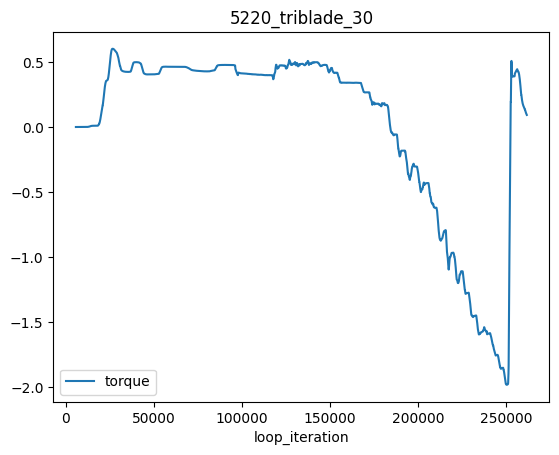

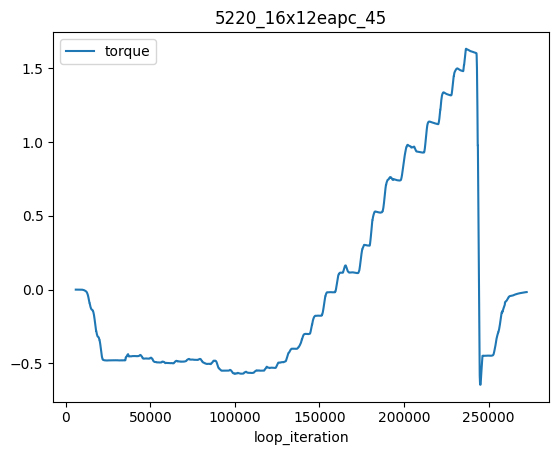

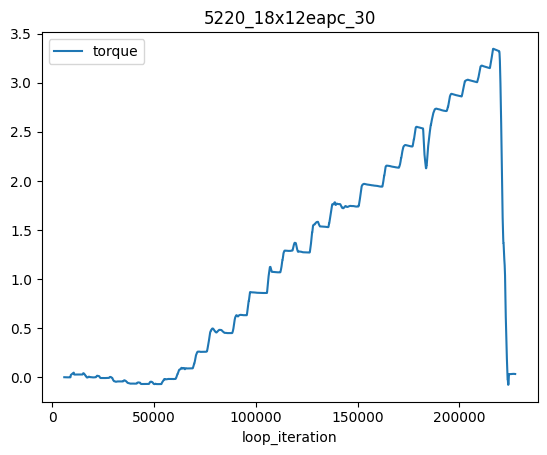

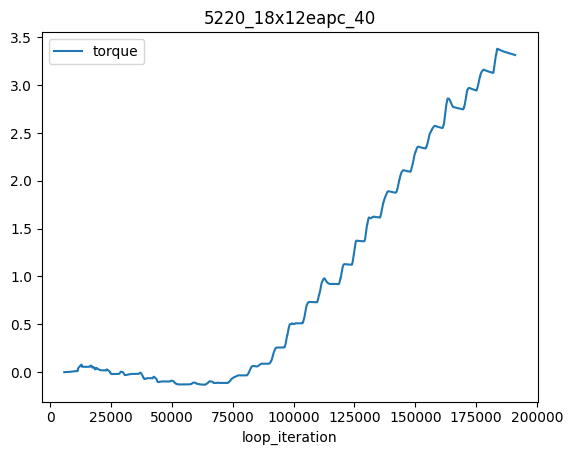

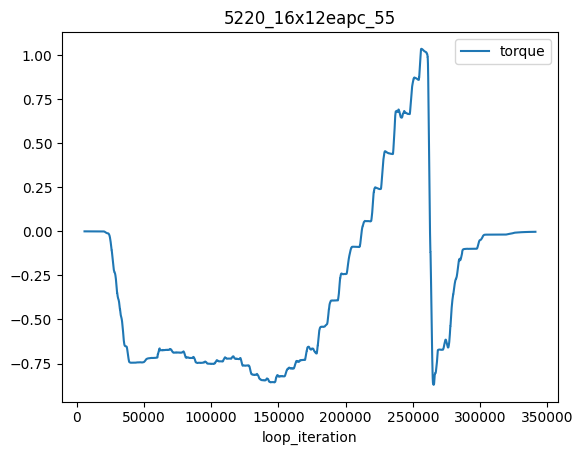

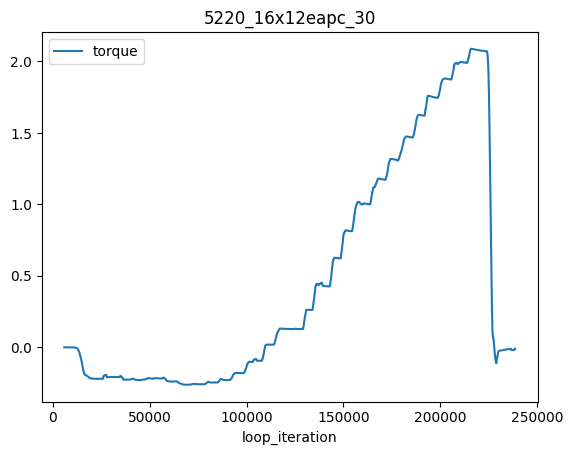

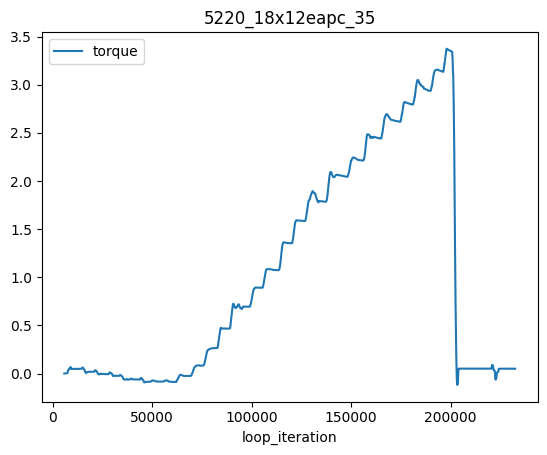

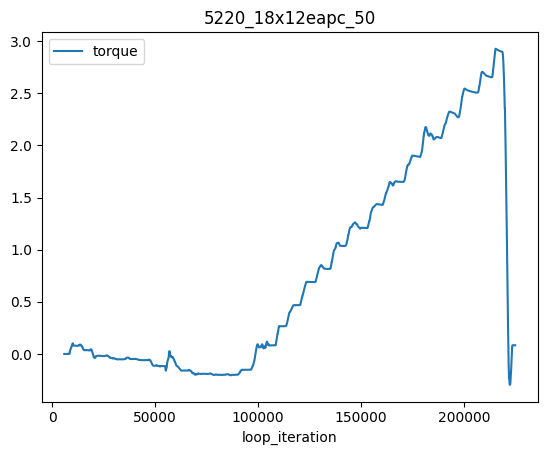

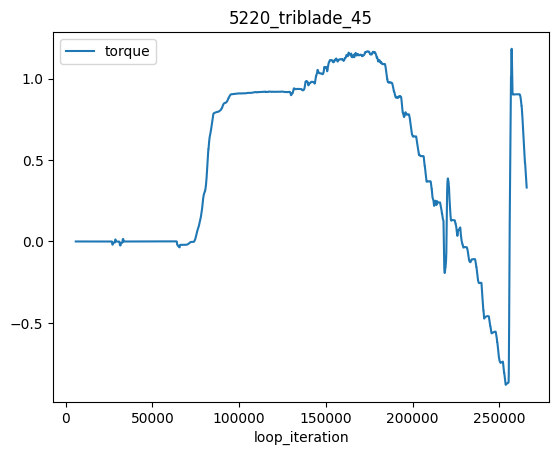

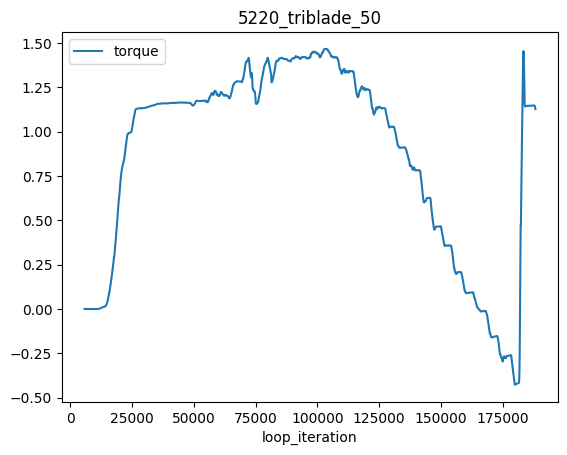

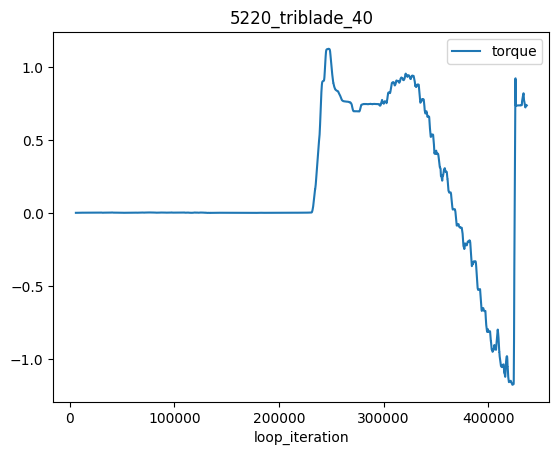

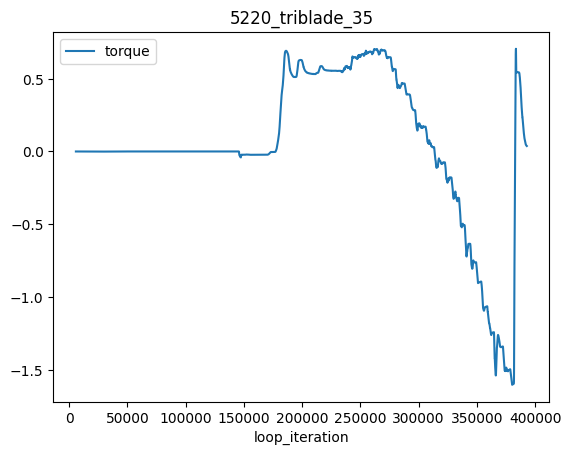

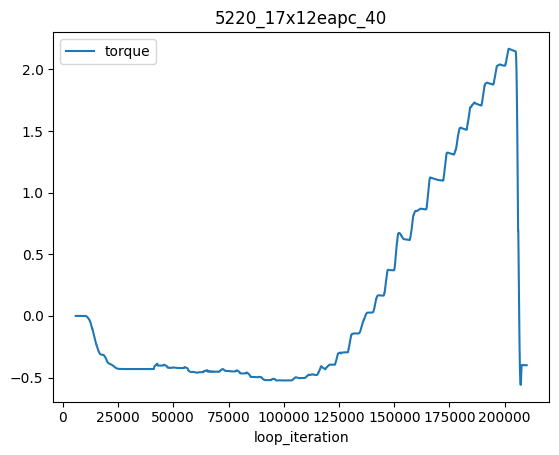

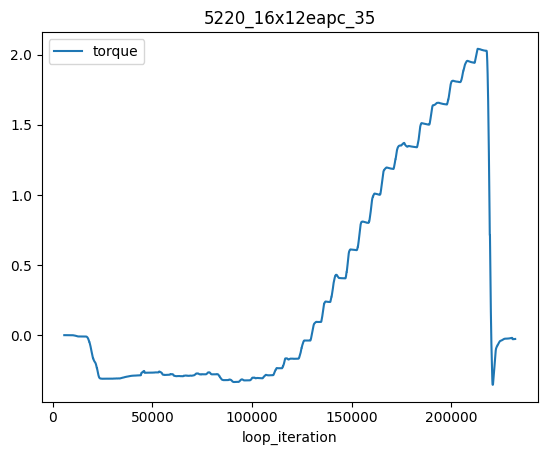

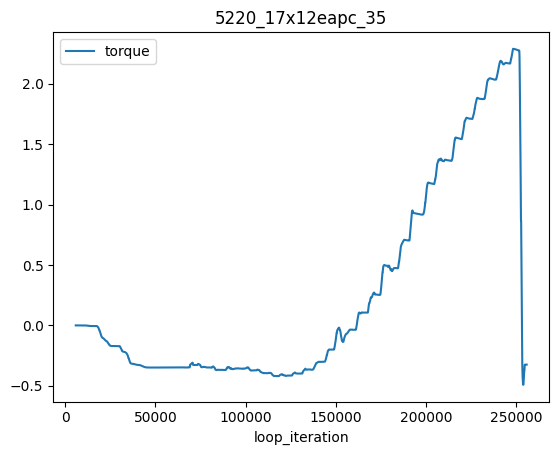

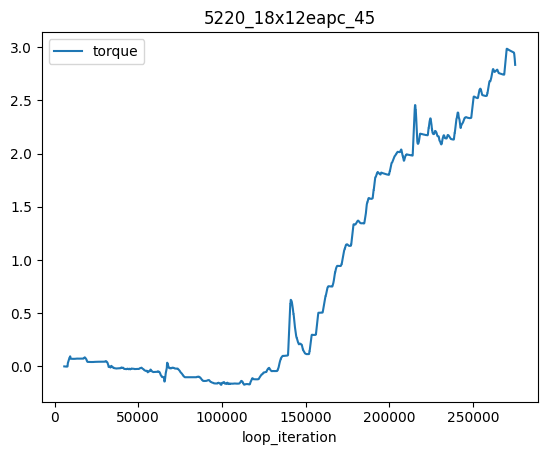

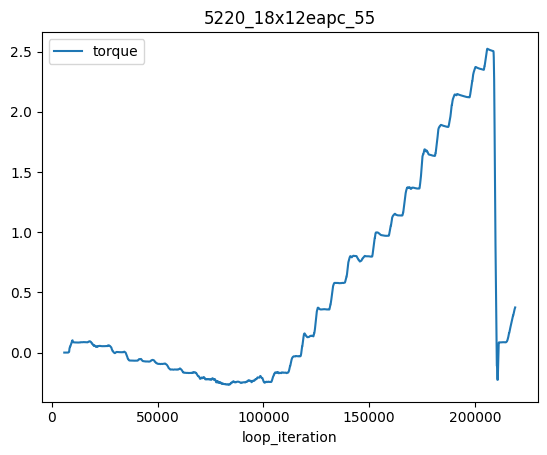

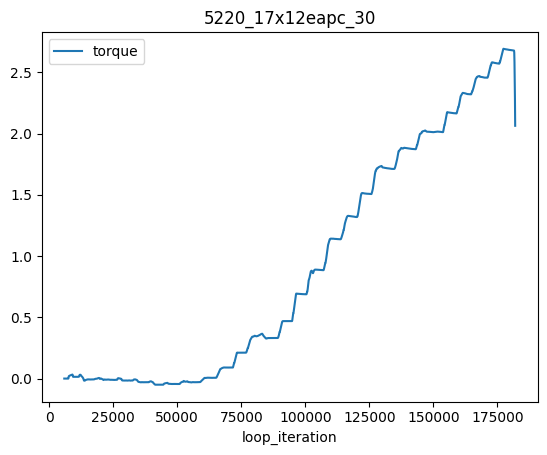

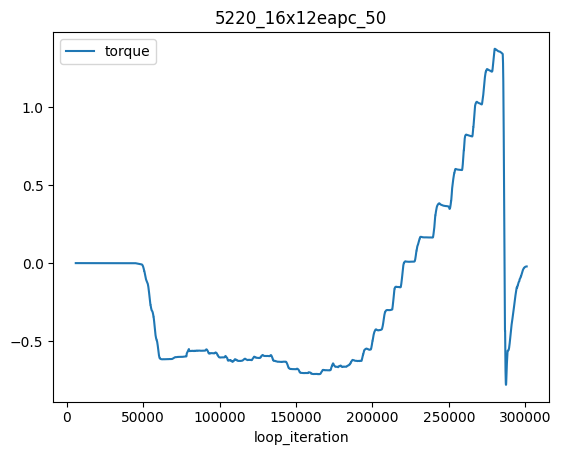

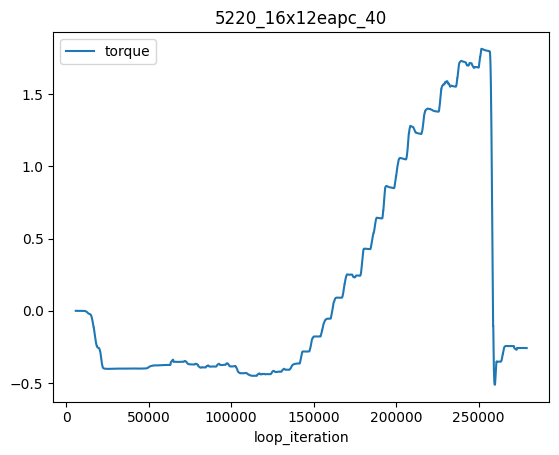

In [53]:
for key in common_dfs:
    torque_dfs[key].plot(x='loop_iteration', y='torque', title=key)

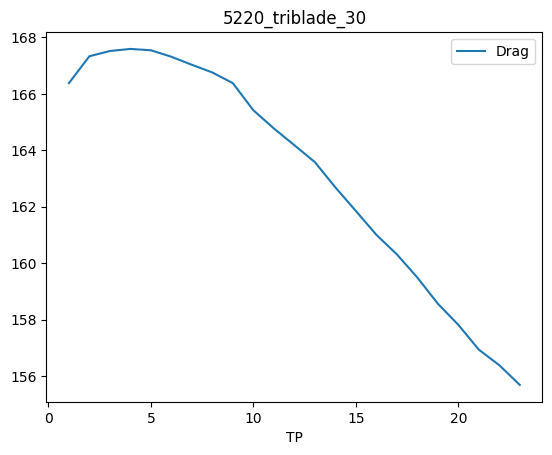

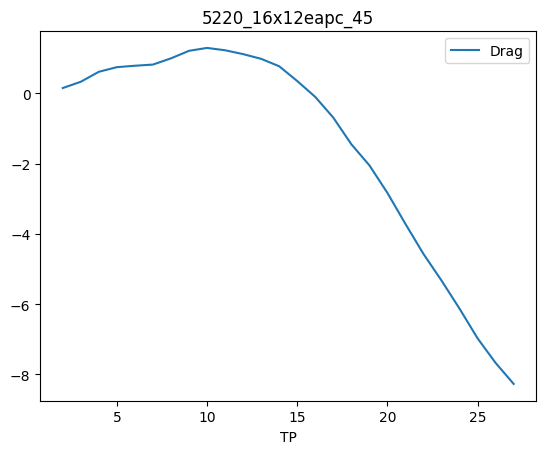

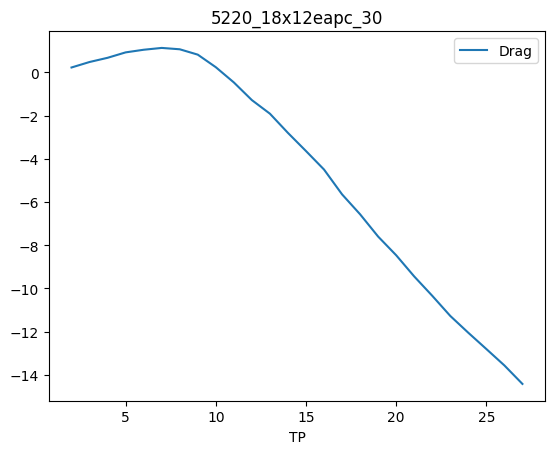

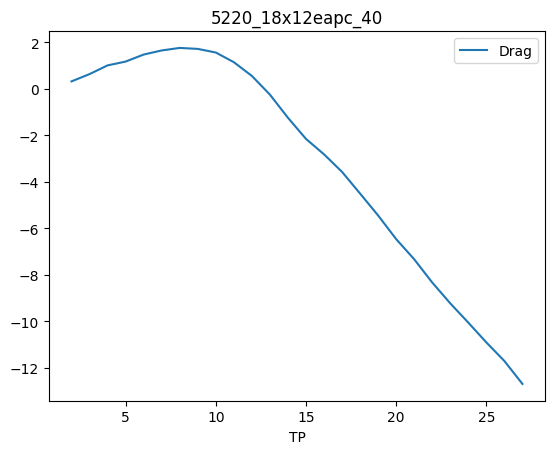

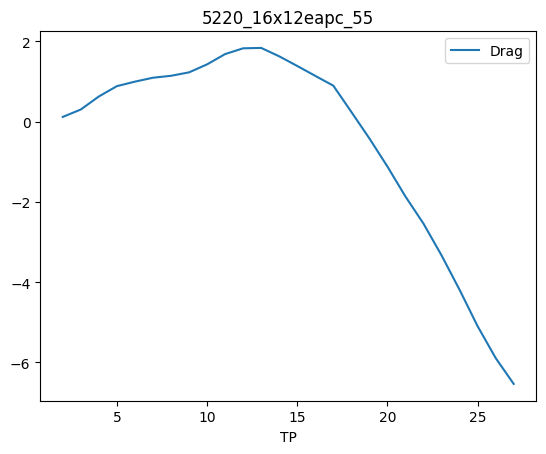

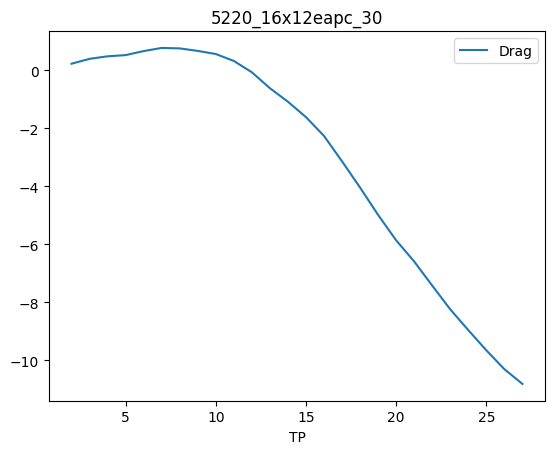

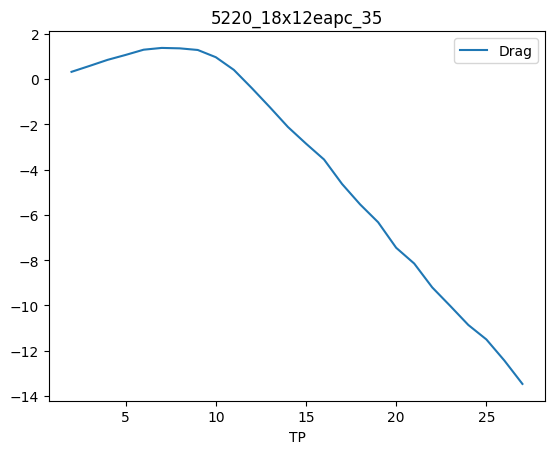

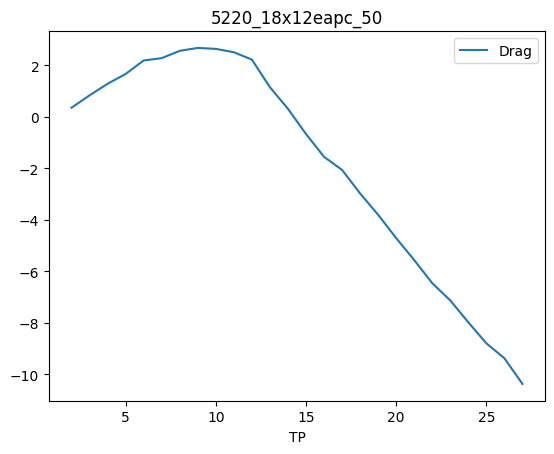

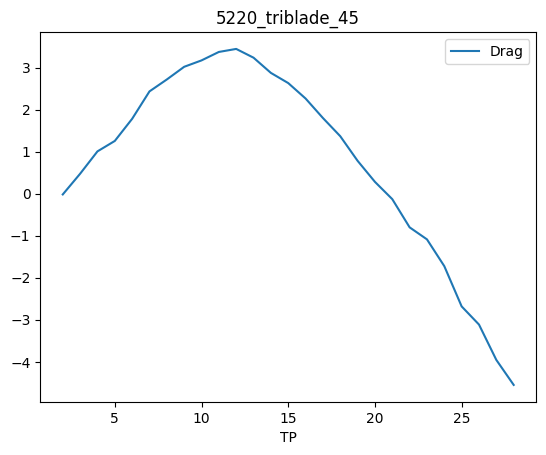

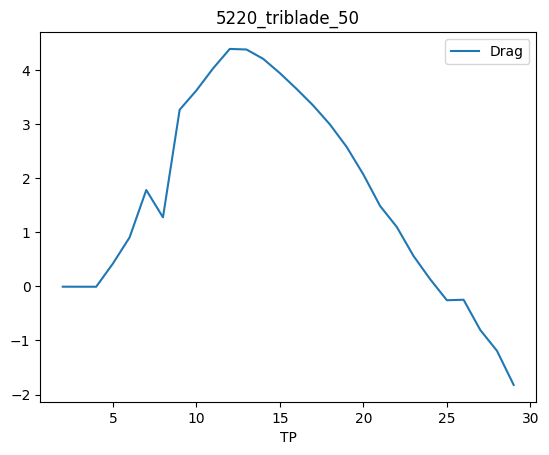

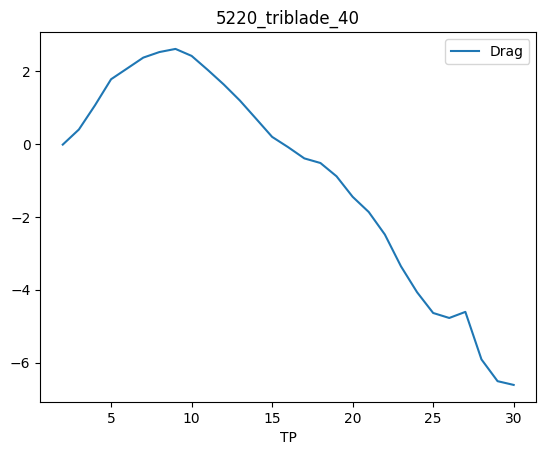

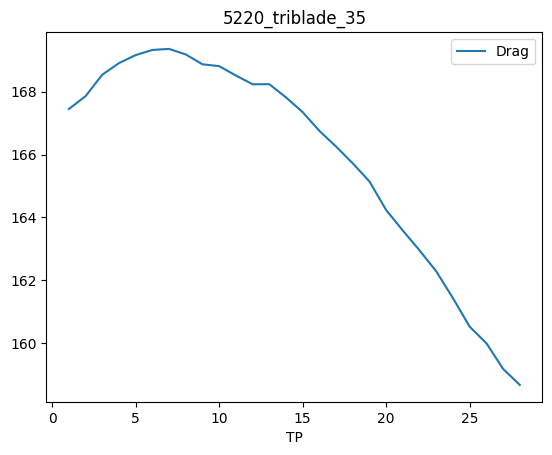

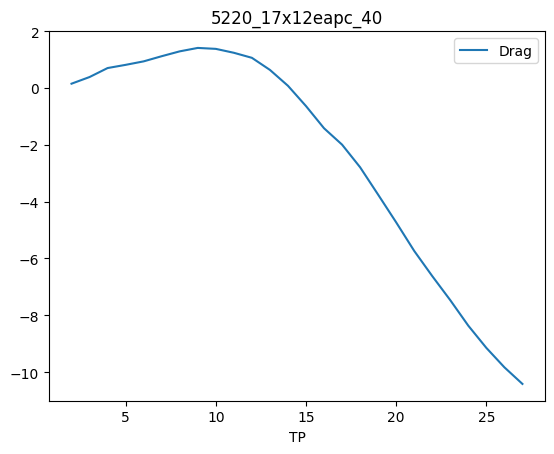

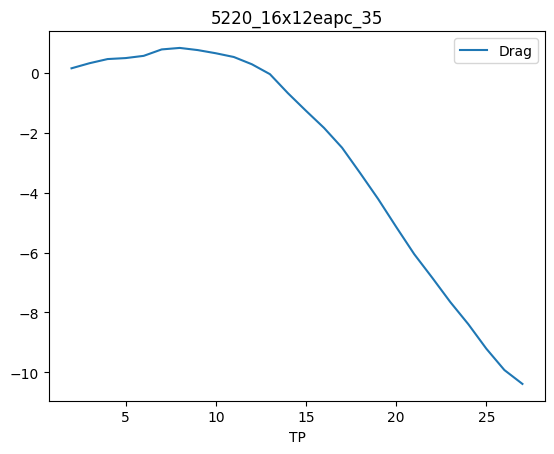

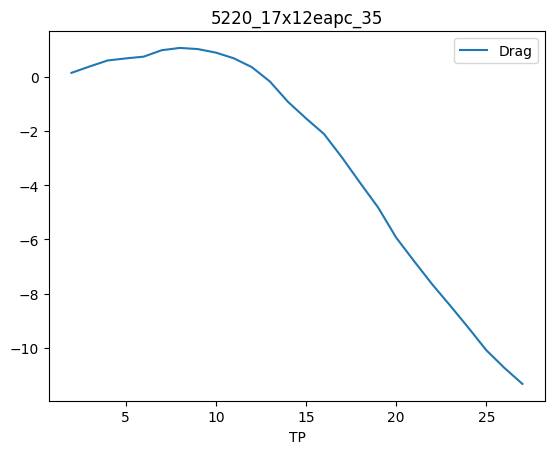

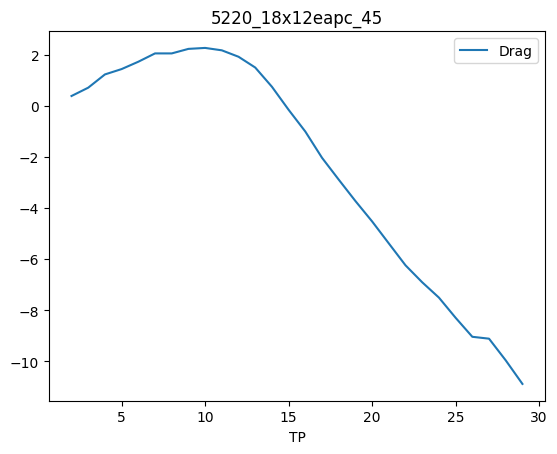

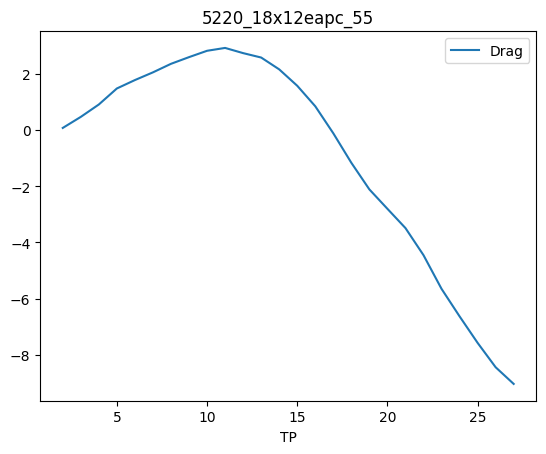

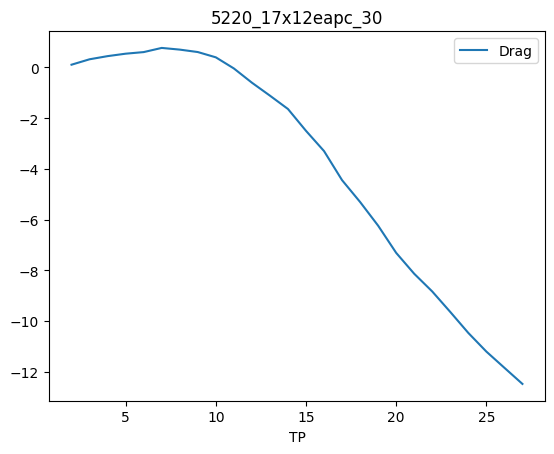

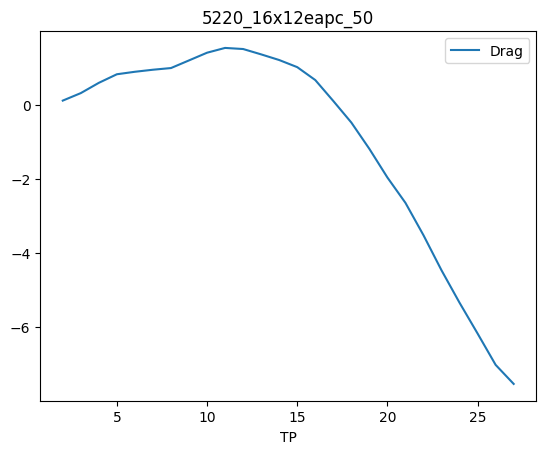

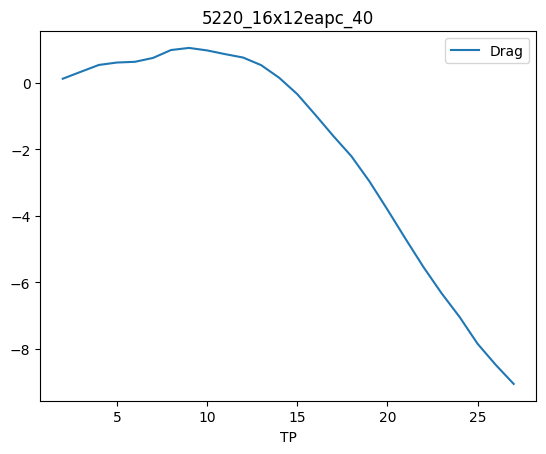

In [47]:
for key in common_dfs:
    thrust_dfs[key].plot(x='TP', y='Drag', title=key)

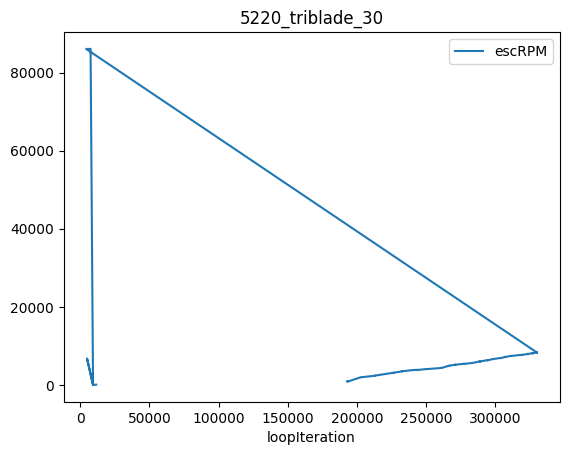

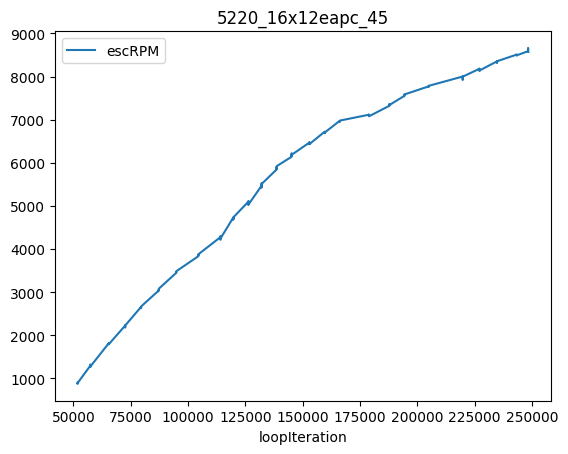

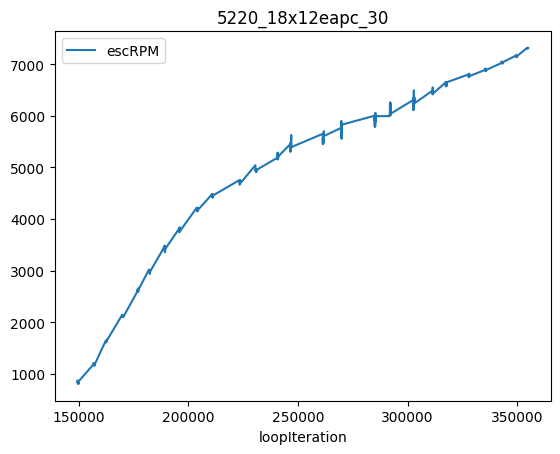

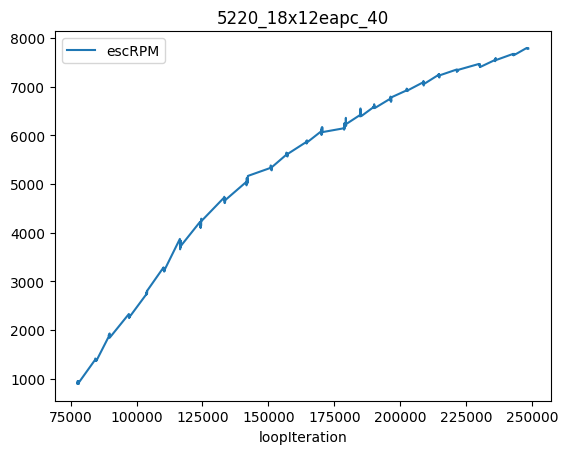

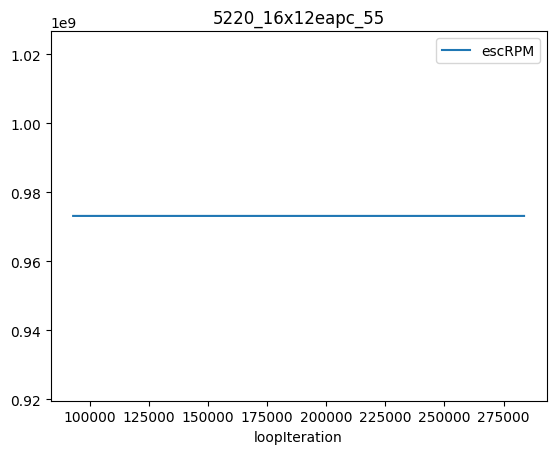

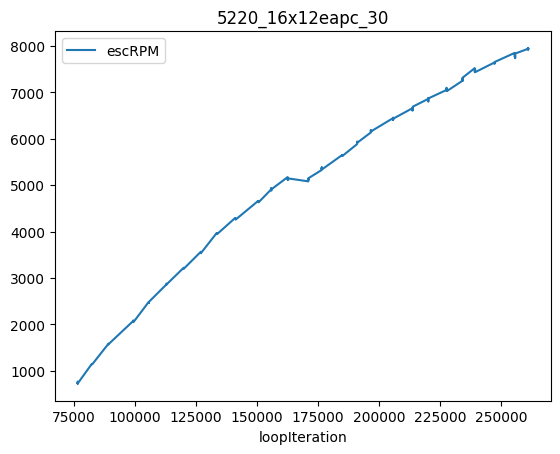

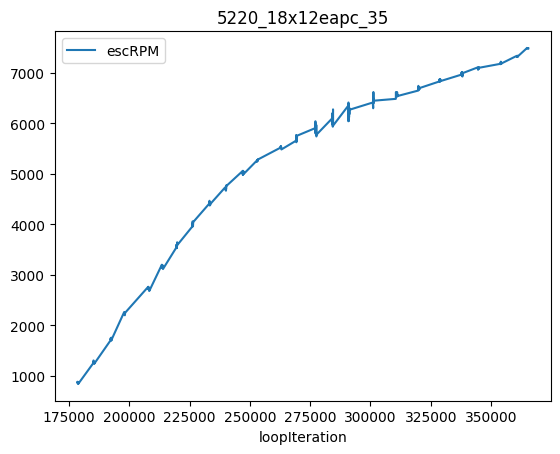

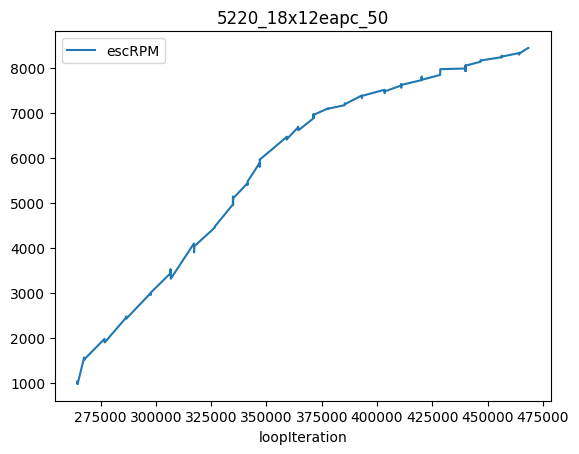

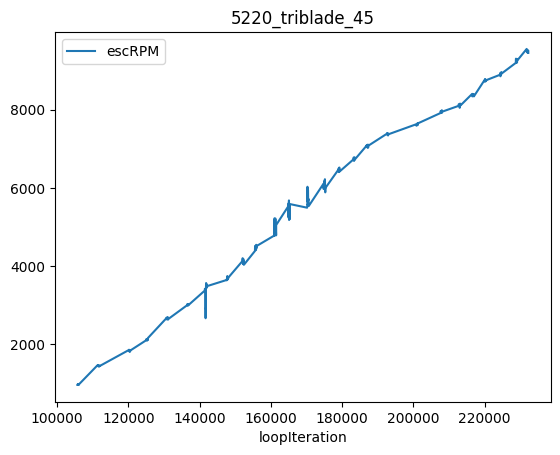

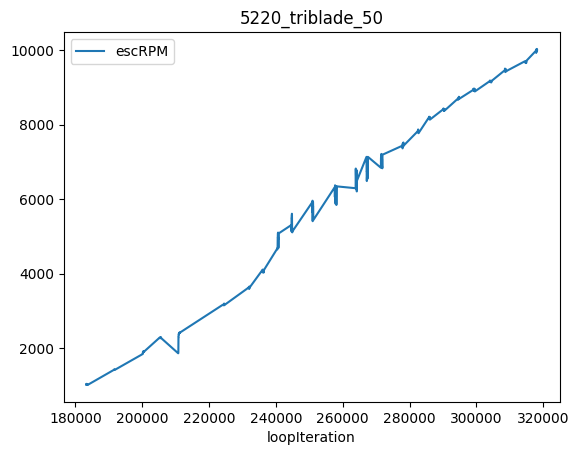

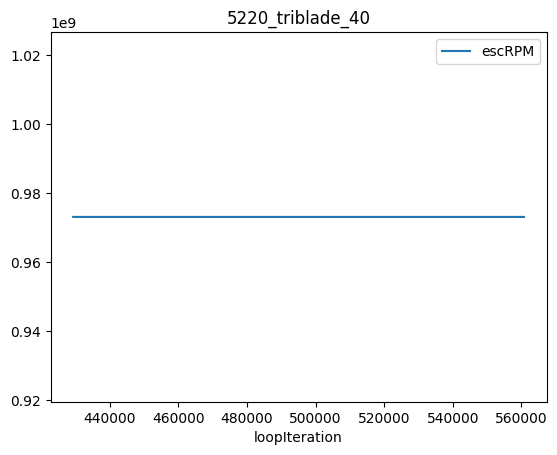

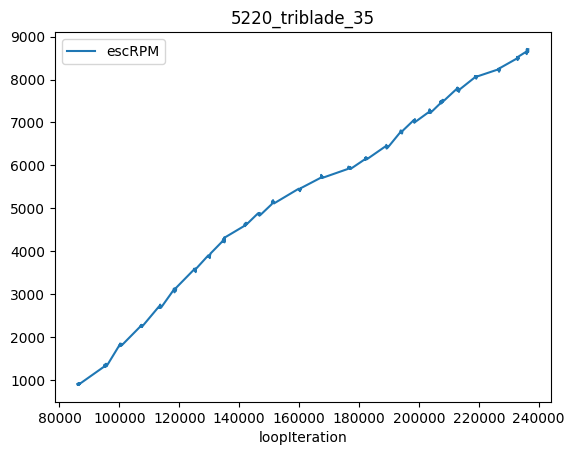

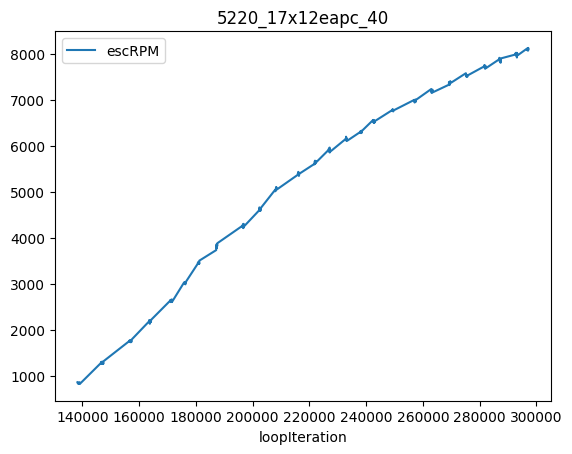

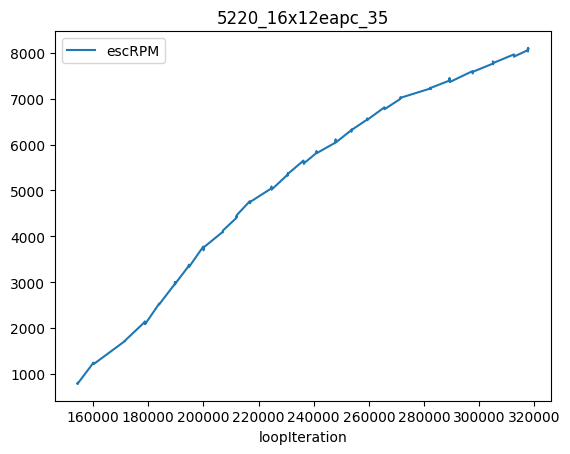

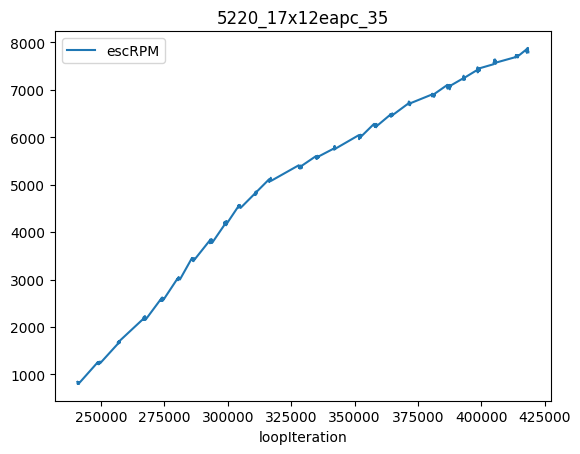

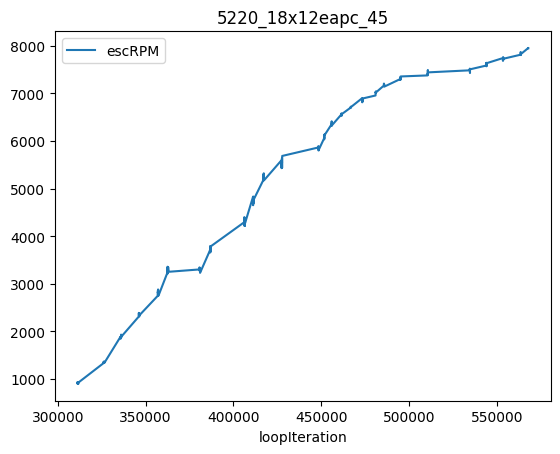

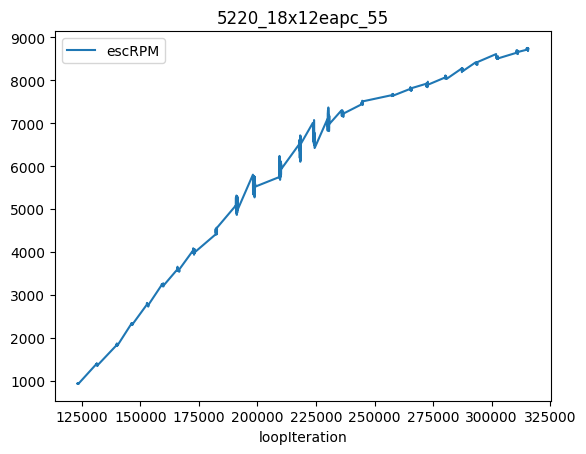

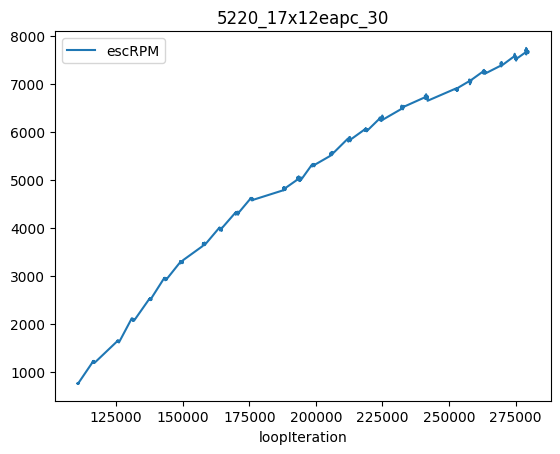

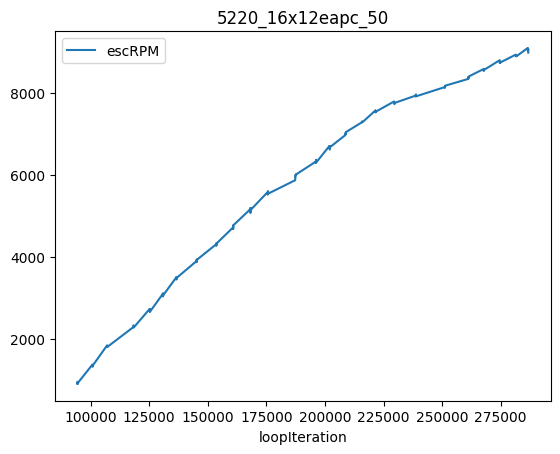

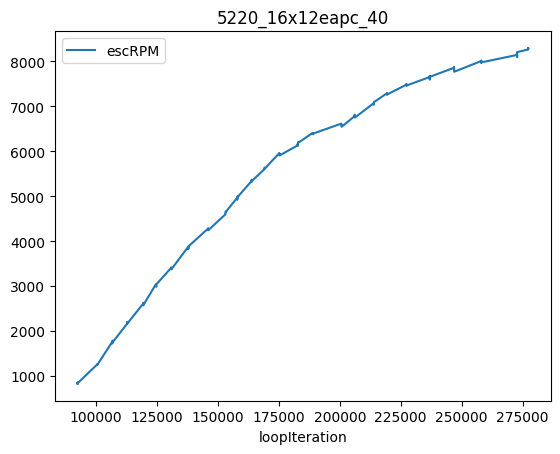

In [56]:
for key in common_dfs:
    blackbox_dfs[key].plot(x='loopIteration', y='escRPM', title=key)

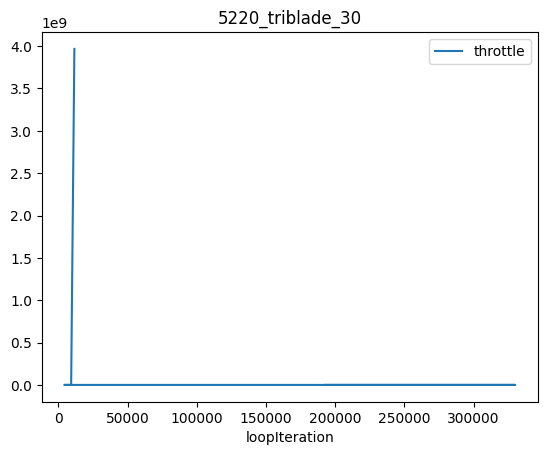

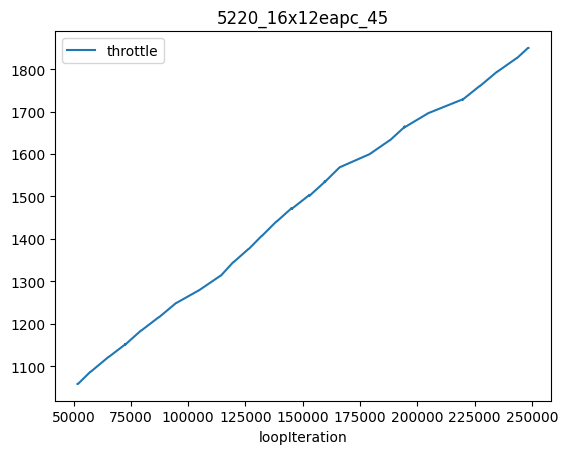

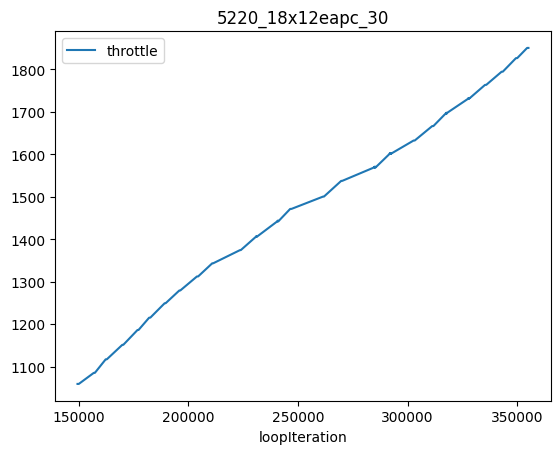

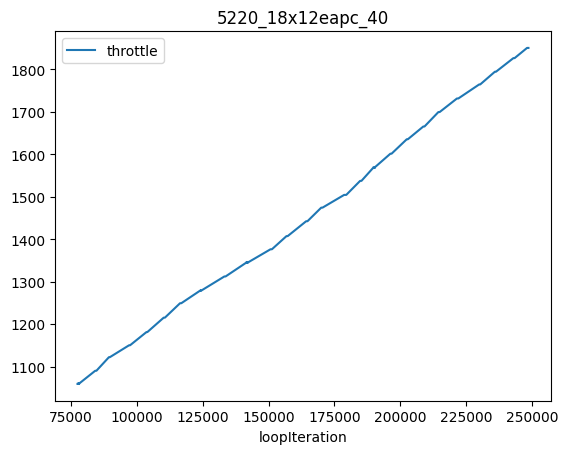

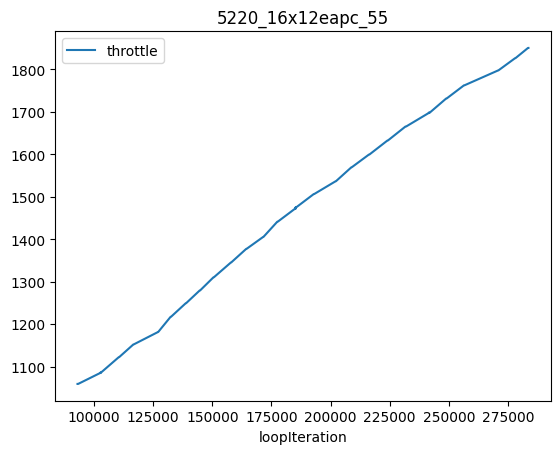

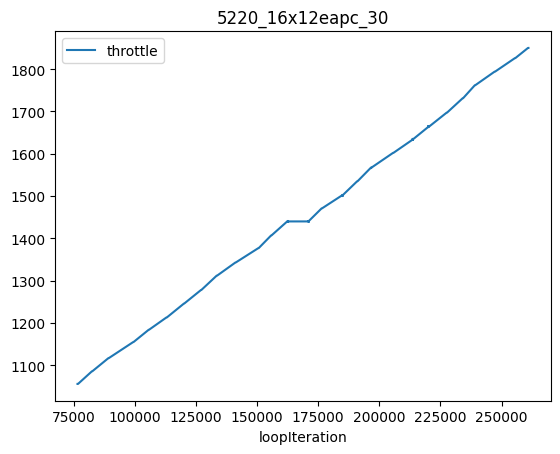

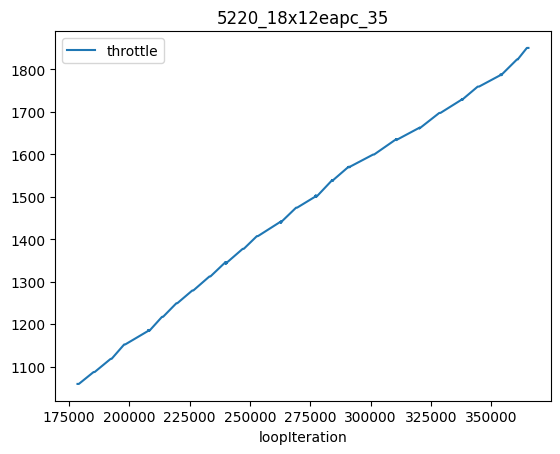

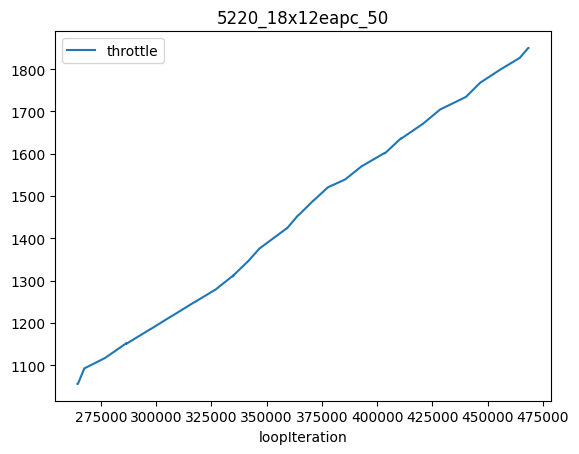

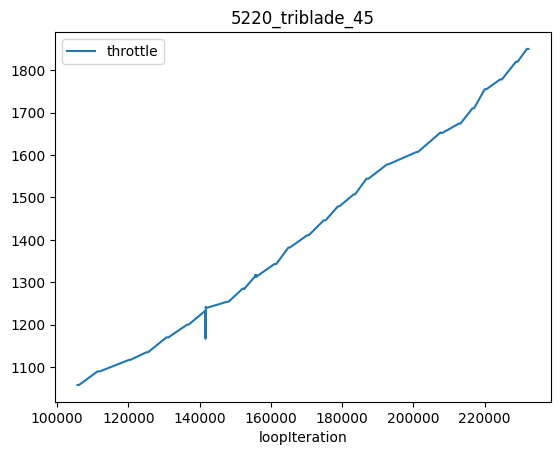

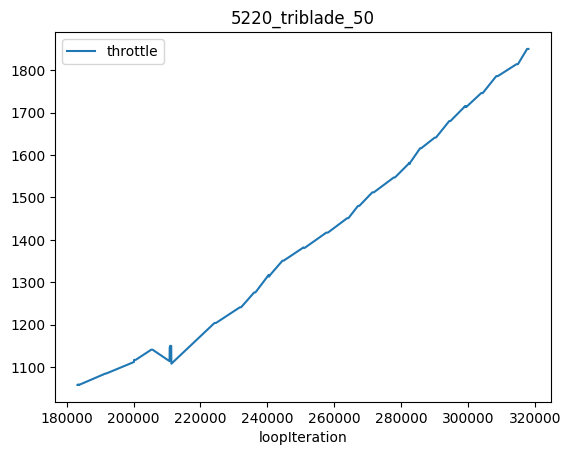

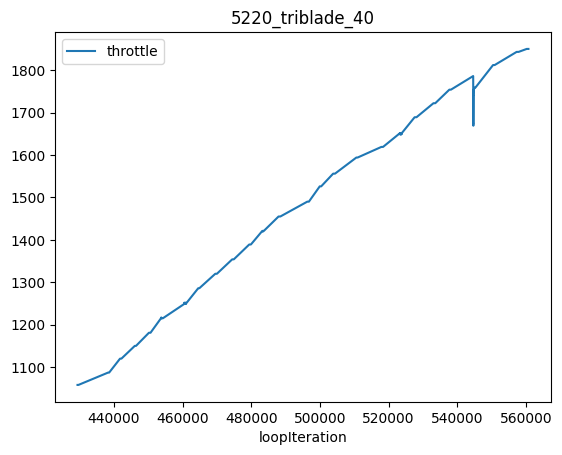

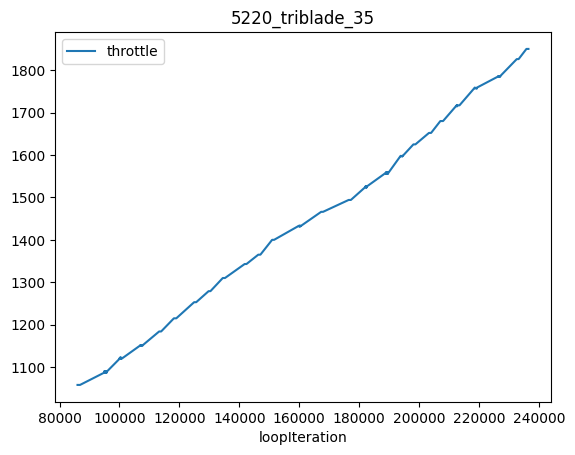

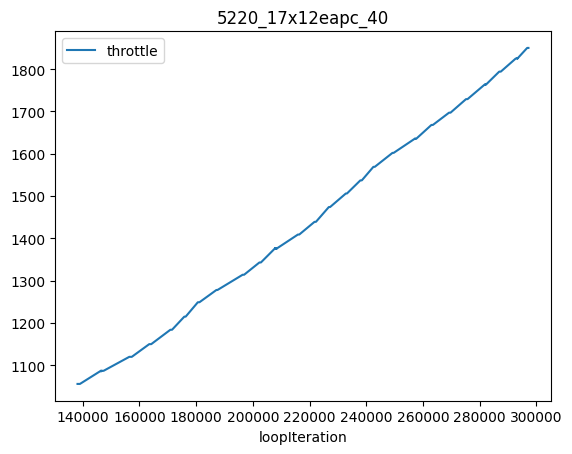

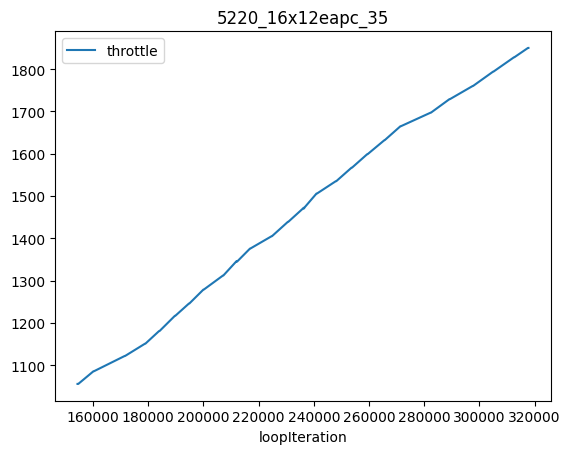

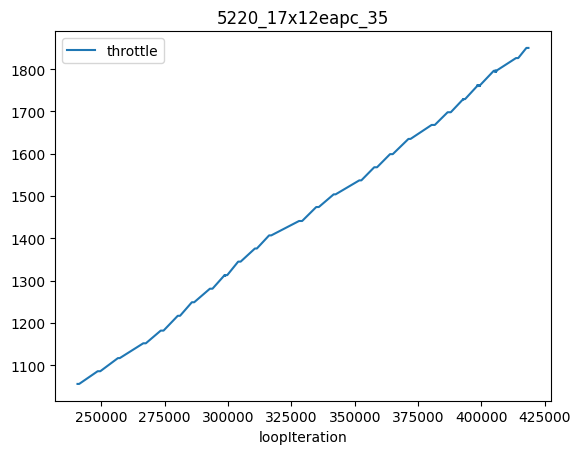

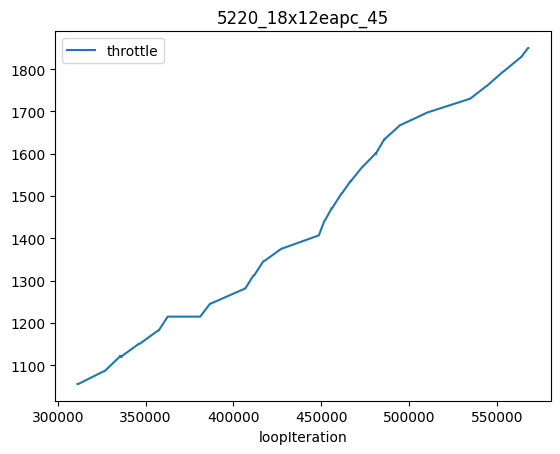

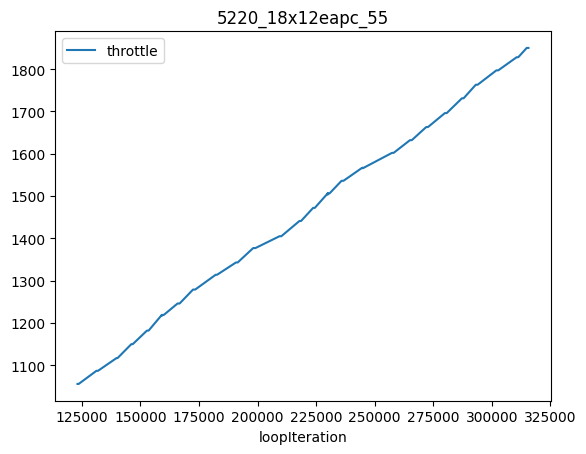

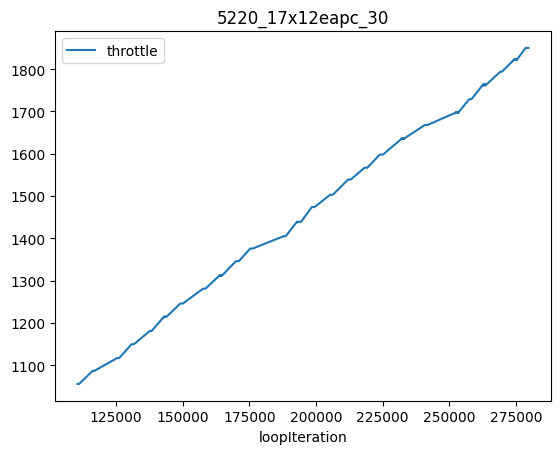

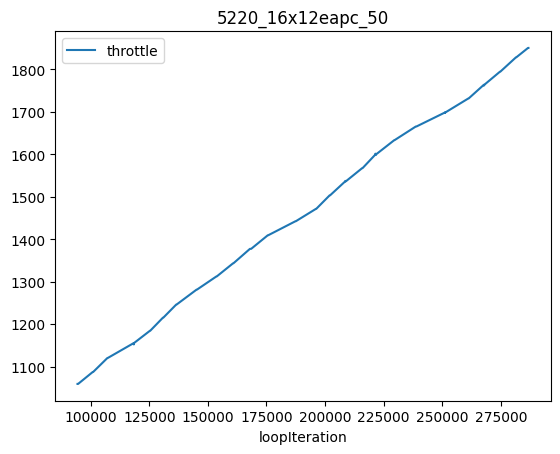

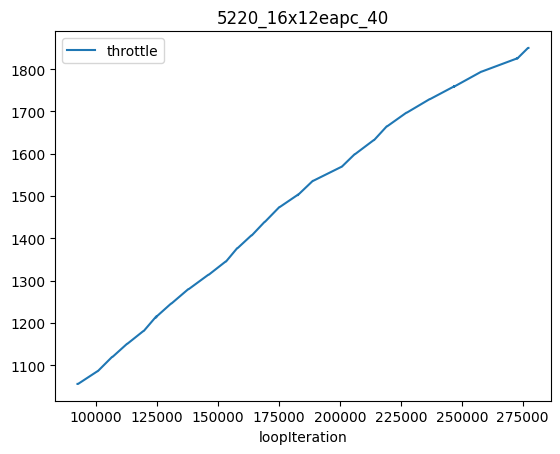

In [55]:
for key in common_dfs:
    blackbox_dfs[key].plot(x='loopIteration', y='throttle', title=key)

In [57]:
common_dfs -= set(['5220_triblade_30', '5220_16x12eapc_55', '5220_triblade_40'])

5220_16x12eapc_45
5220_18x12eapc_30
5220_18x12eapc_40
5220_16x12eapc_30
5220_18x12eapc_35
5220_18x12eapc_50
5220_triblade_45


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


5220_triblade_50
5220_triblade_35
5220_17x12eapc_40
5220_16x12eapc_35
5220_17x12eapc_35
5220_18x12eapc_45
5220_18x12eapc_55
5220_17x12eapc_30
5220_16x12eapc_50
5220_16x12eapc_40


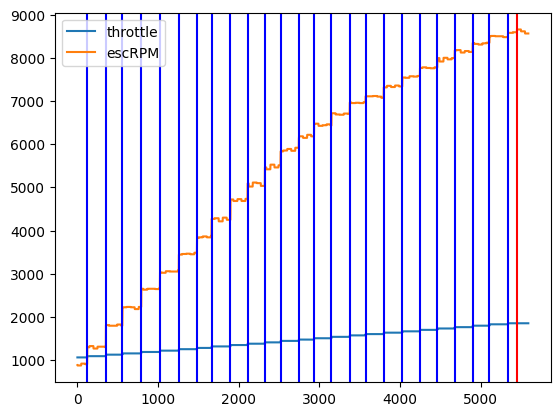

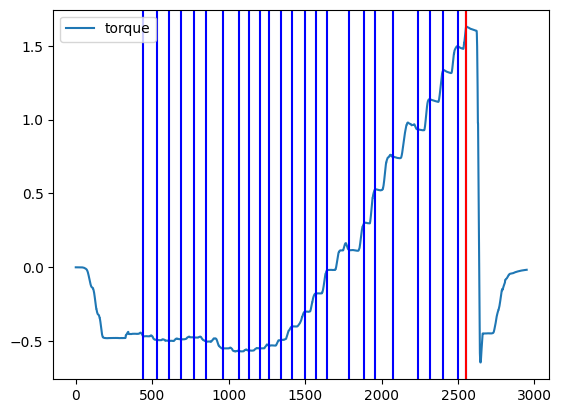

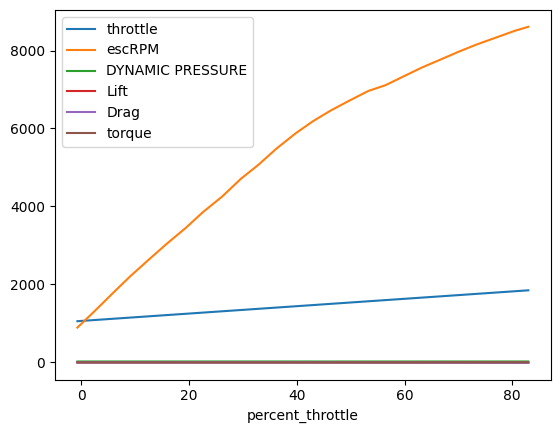

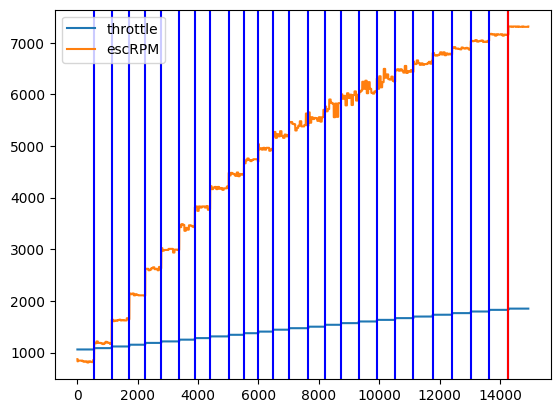

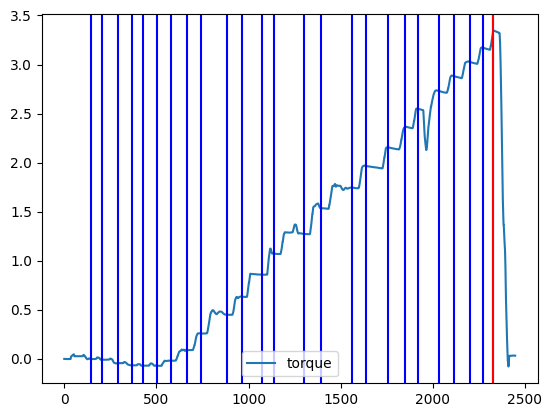

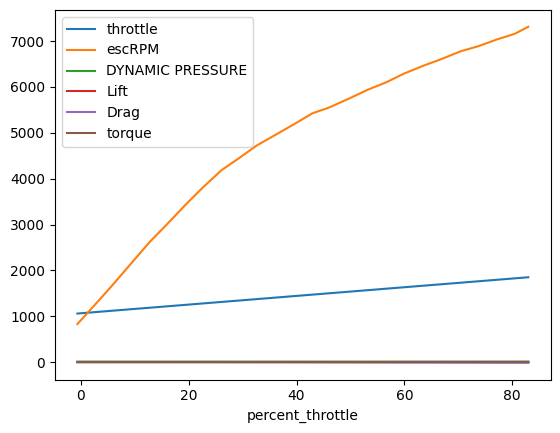

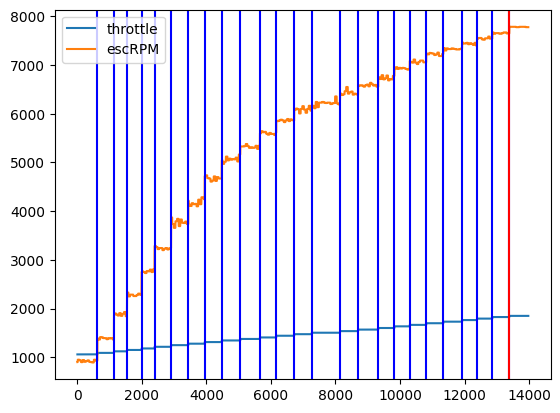

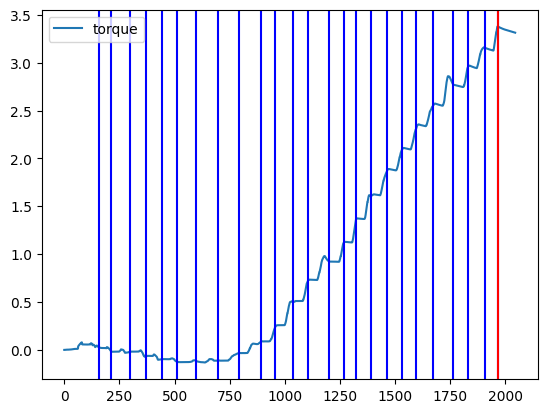

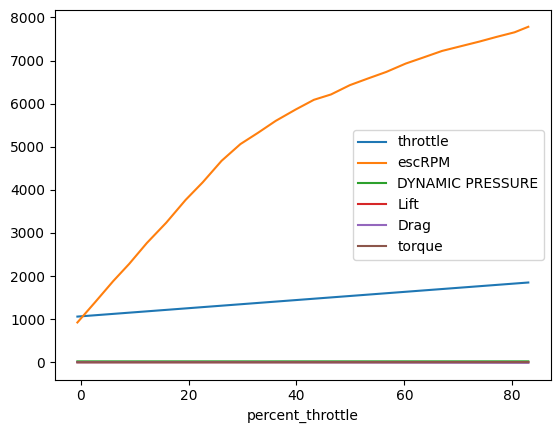

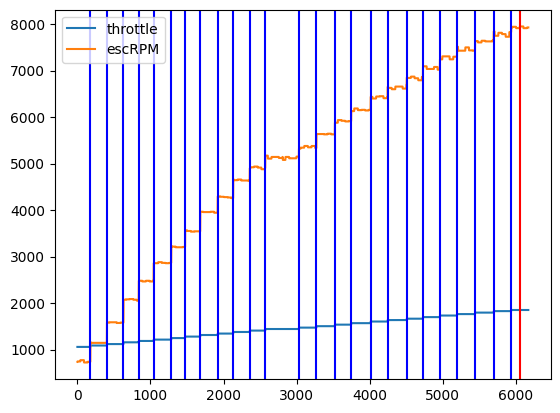

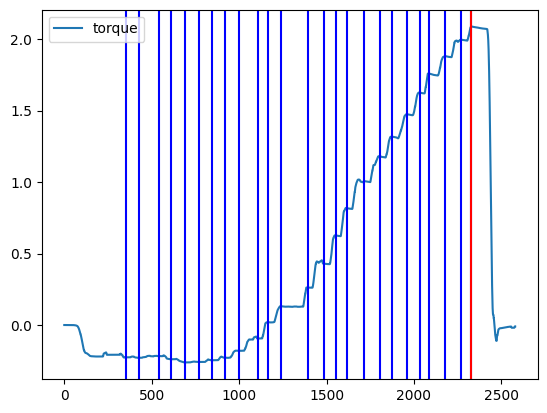

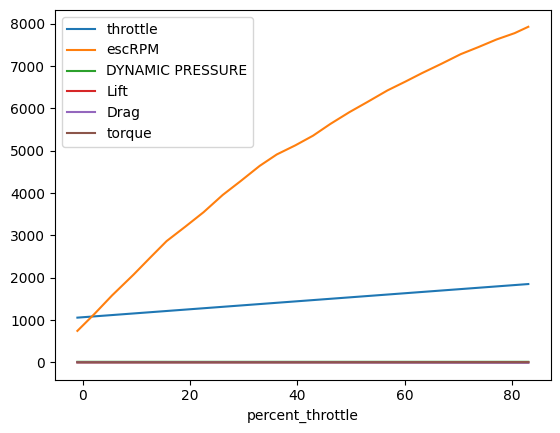

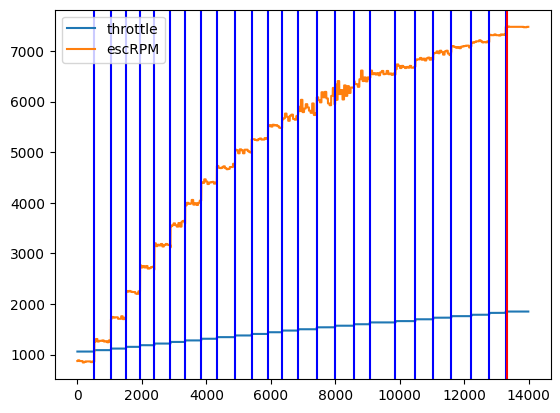

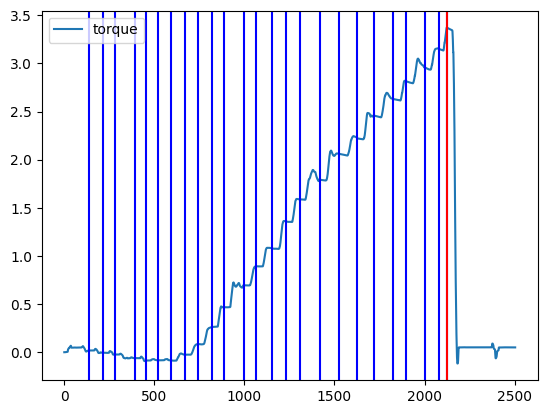

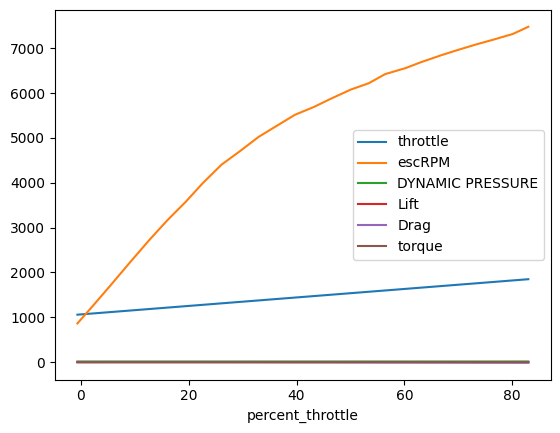

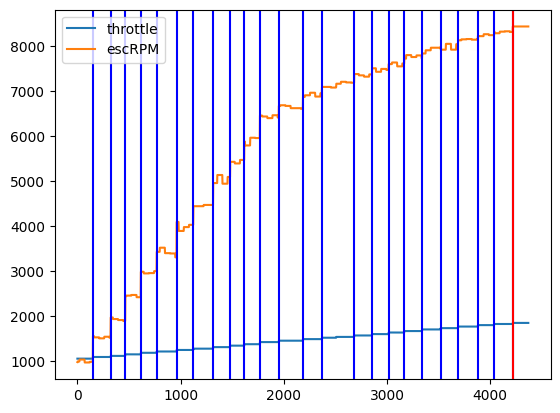

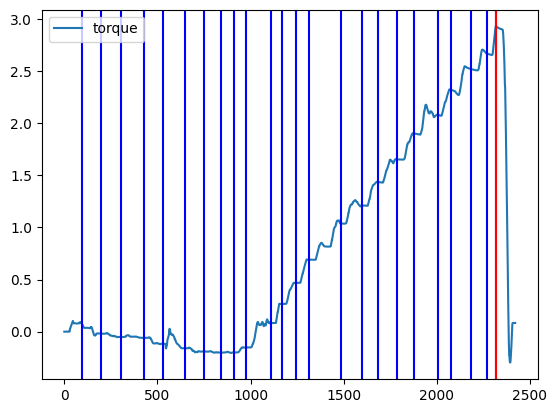

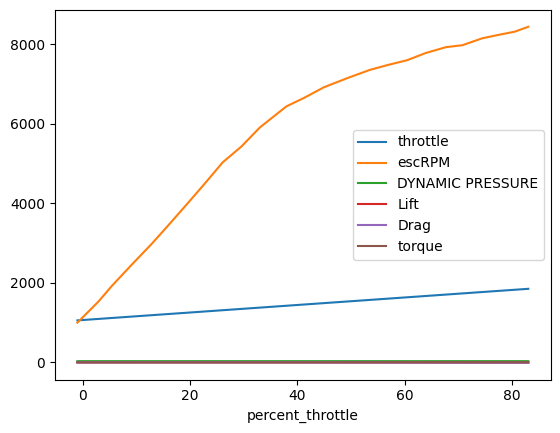

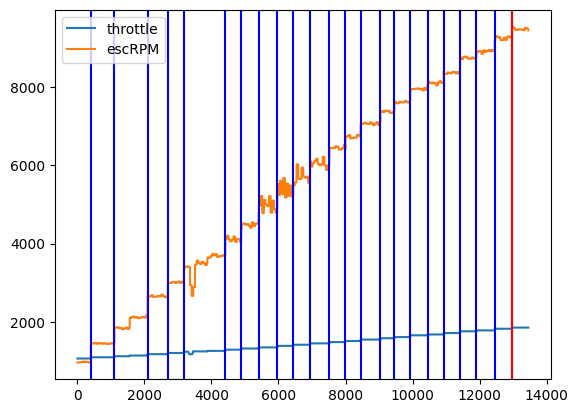

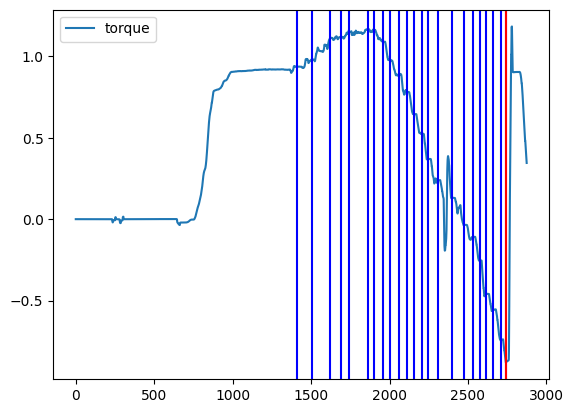

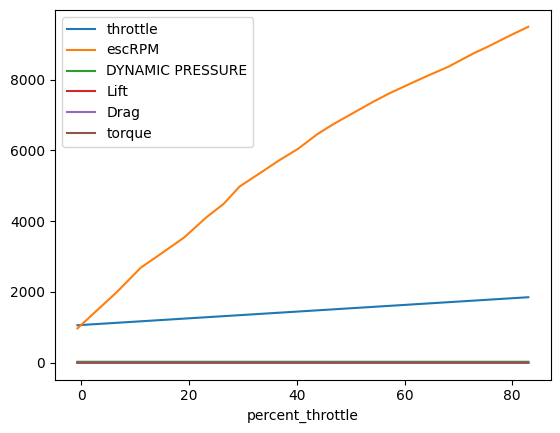

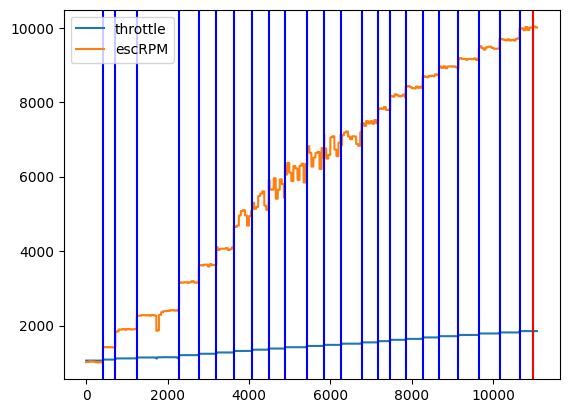

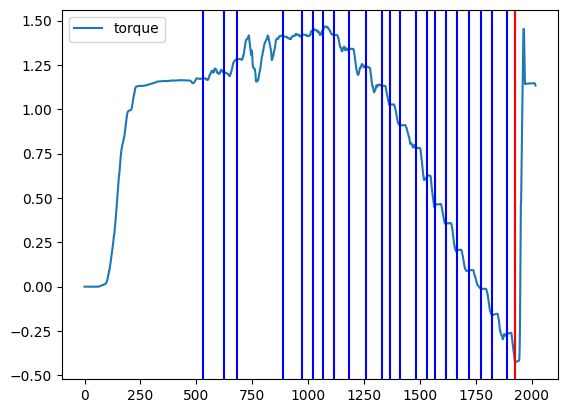

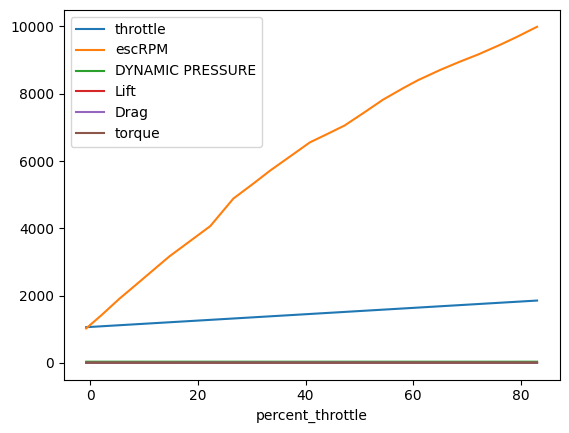

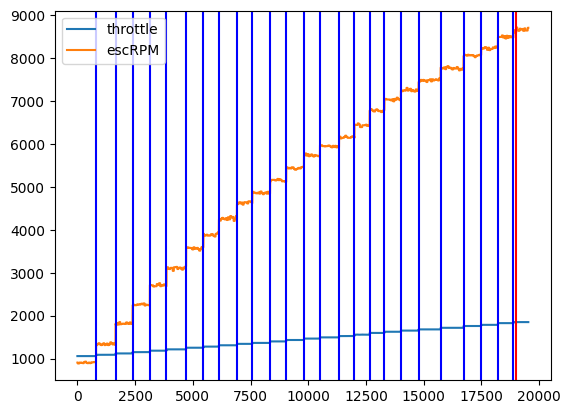

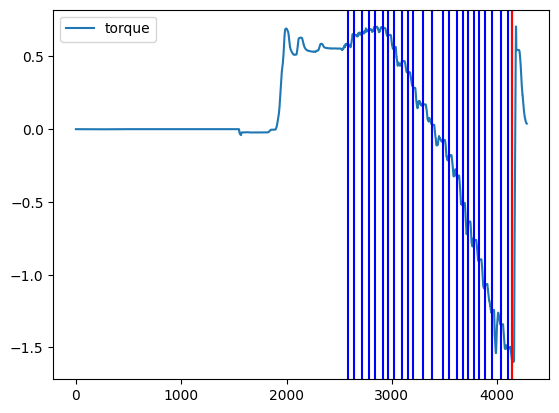

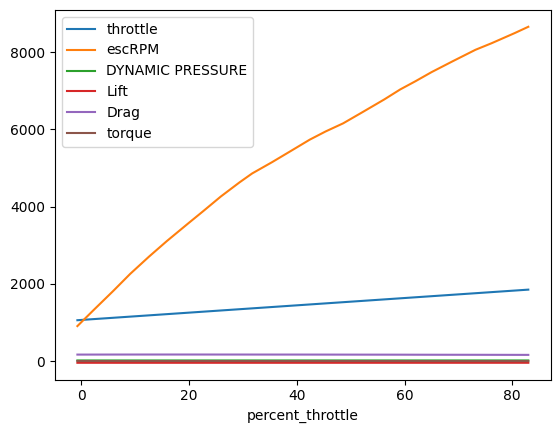

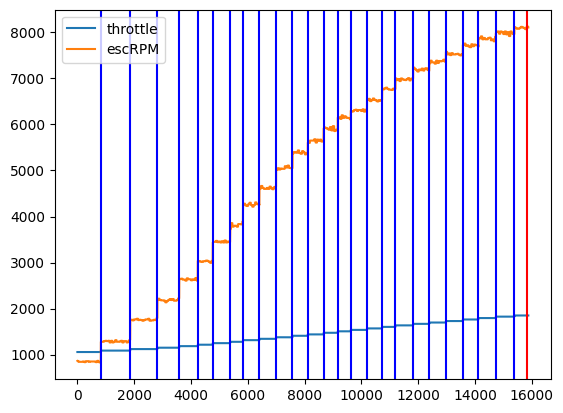

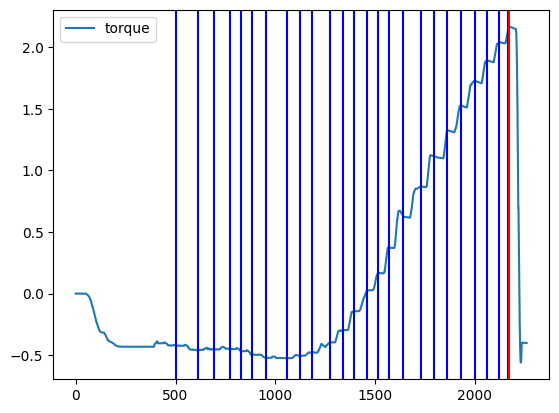

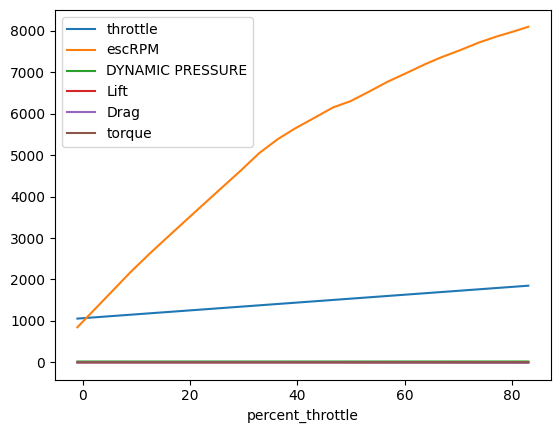

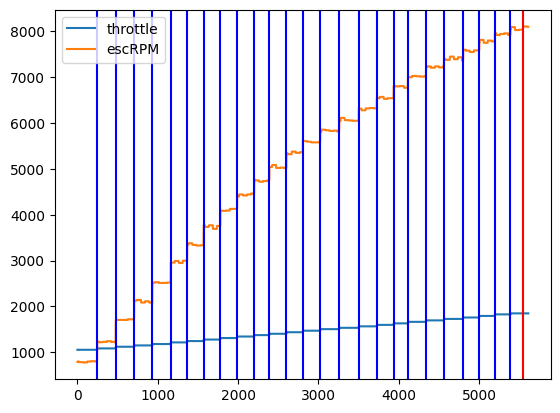

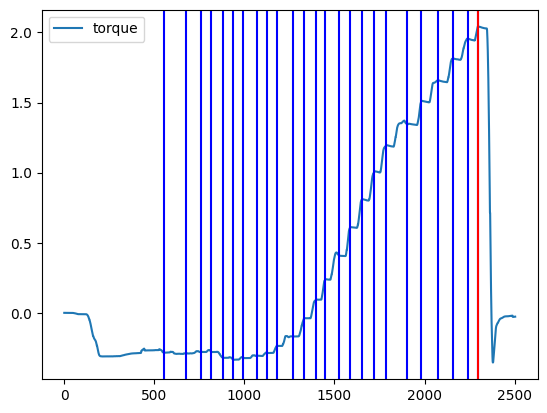

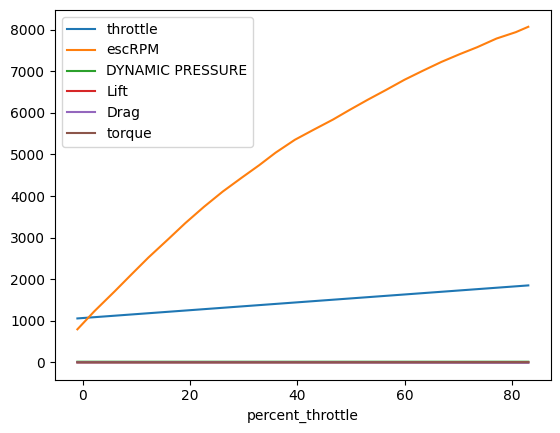

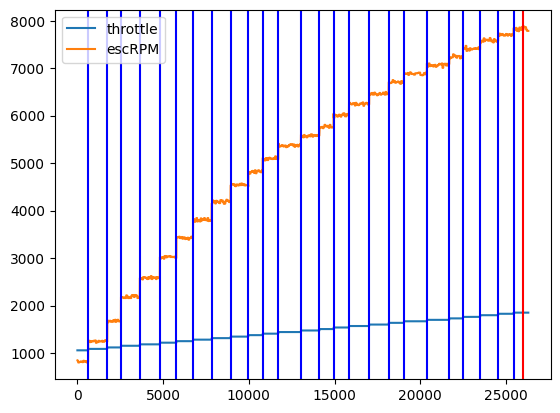

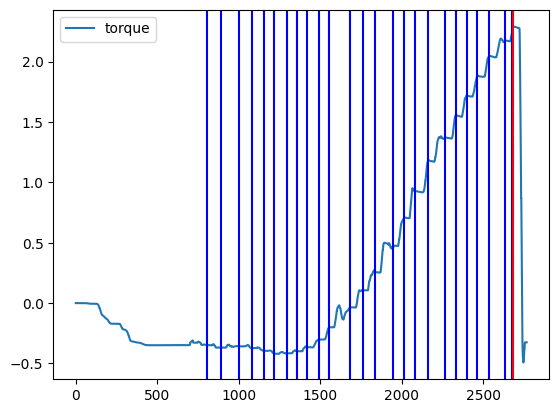

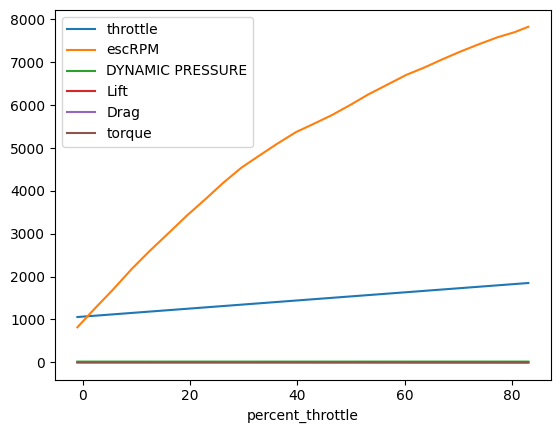

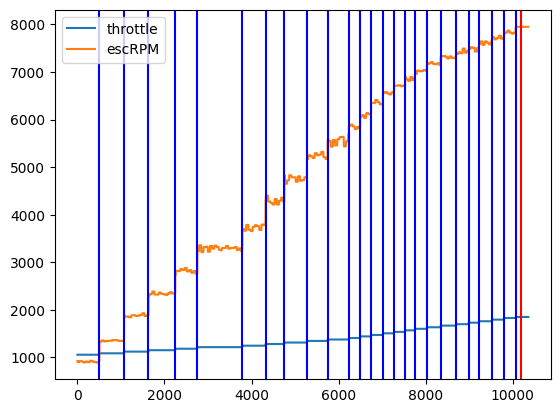

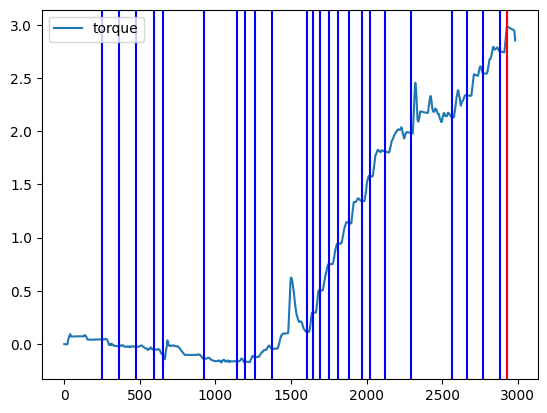

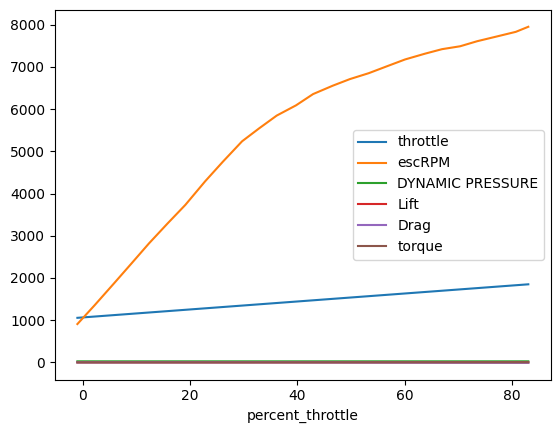

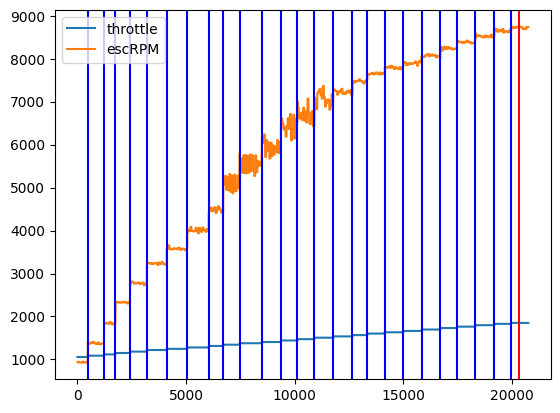

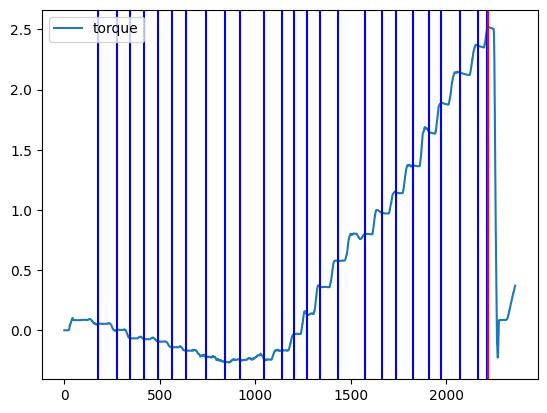

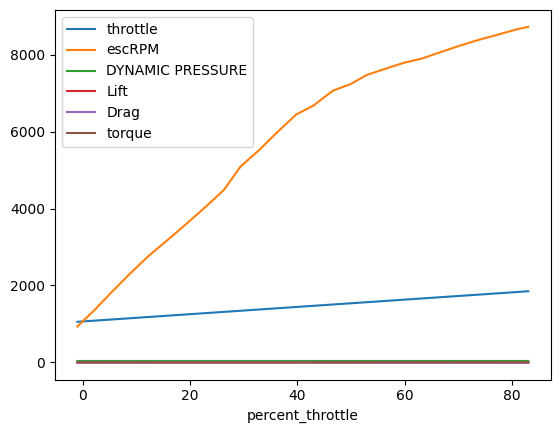

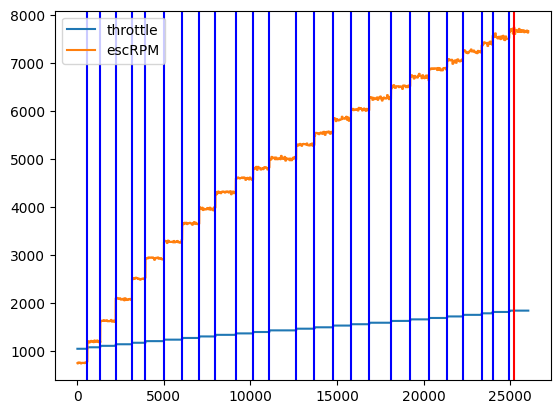

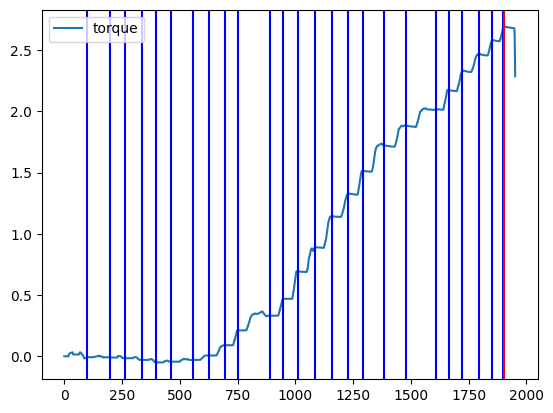

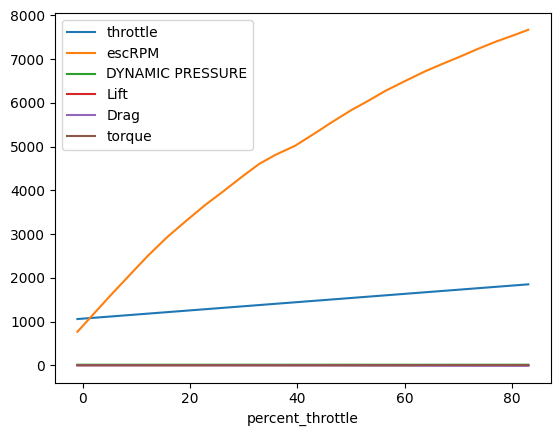

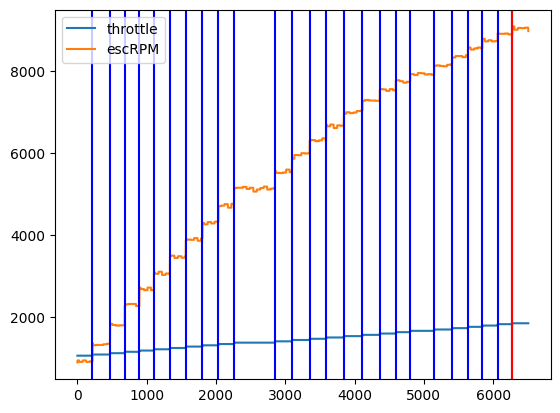

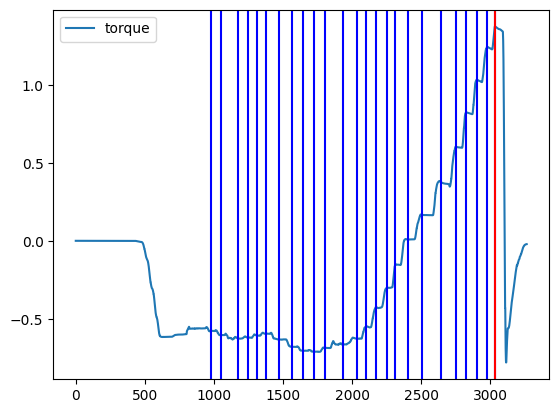

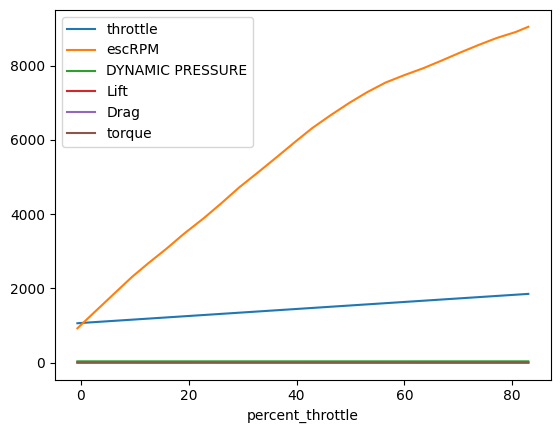

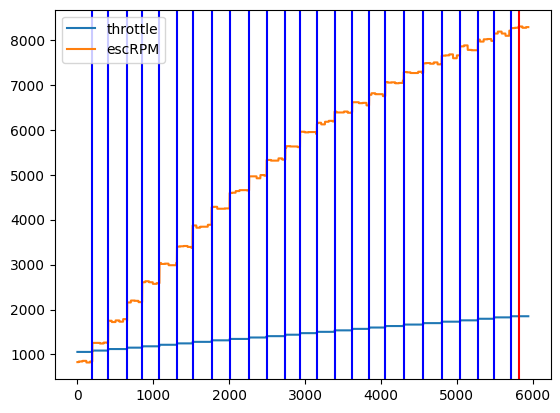

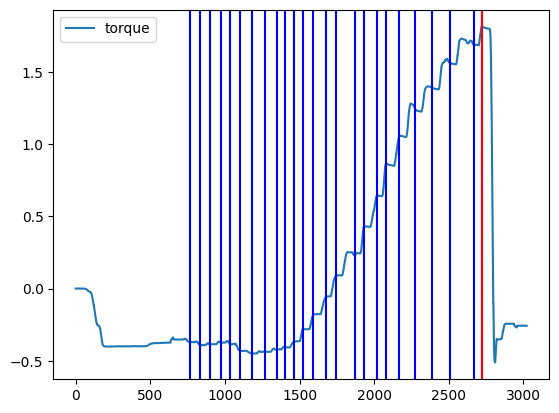

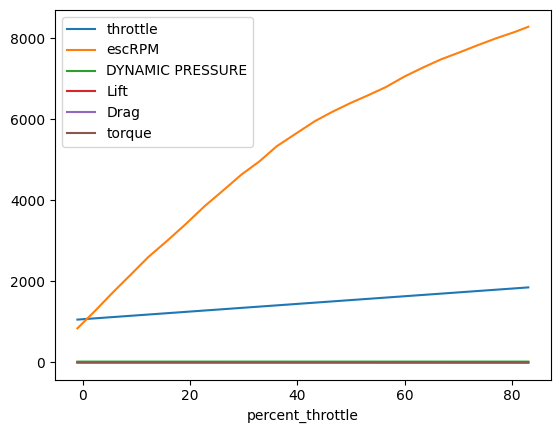

In [61]:
BLACKBOX_COLS = ['throttle', 'escRPM']
THRUST_COLS = ['DYNAMIC PRESSURE', 'Lift', 'Drag']
TORQUE_COLS = ['torque']
METADATA = ['motor', 'prop', 'airspeed']

for name in list(common_dfs):
    print(name)

    metadata = dict(zip(METADATA, name.split("_")))

    df = blackbox_dfs[name][['loopIteration'] + BLACKBOX_COLS].copy()
    bins = df['throttle'].index[(df['throttle'] - df['throttle'].shift(1)).apply(lambda x: x > 20)].tolist()
    bin_cutoffs = df['loopIteration'][bins].tolist()
    df[BLACKBOX_COLS].plot()
    for x in bins:
        plt.axvline(x = x, color = 'b', label = 'axvline - full height')
    plt.axvline(x = df['escRPM'].idxmax(), color = 'r', label = 'axvline - full height')
    plt.savefig(OUTPUT_DIR + "/" + name + "_alignment.png")
    df['throttle_group'] = pd.qcut(df["throttle"], q=[0] + [val / len(df["throttle"]) for val in bins] + [1], labels=list(map(str, bins)) + ["max"])
    df = df.groupby('throttle_group').mean()
    df.reset_index(inplace=True)
    df.drop(columns=['throttle_group'], inplace=True)

    df_torque = torque_dfs[name][['loop_iteration'] + TORQUE_COLS].copy()
    df_torque['loop_iteration'] = df_torque['loop_iteration'].astype(float)
    df_torque = df_torque.sort_values(by='loop_iteration')
    df_torque = df_torque.iloc[:-1] # drop last row because sometimes it is messed up
    df_torque = df_torque.reset_index(drop=True)
    peak_rpm = blackbox_dfs[name]['loopIteration'][blackbox_dfs[name]['escRPM'].idxmax()]
    # find point with greatest change in torque
    # peak_torque_ix = df_torque['torque'].diff().abs().idxmax()
    # find point with greatest absolute torque
    # peak_torque_ix = df_torque['torque'].abs().idxmax()
    # find the point with the greatest absolute deviation from the mean
    peak_torque_ix = df_torque['torque'].sub(df_torque['torque'].mean()).abs().idxmax()
    peak_torque = df_torque['loop_iteration'][peak_torque_ix]
    offset = peak_rpm - peak_torque
    torque_bins = []
    for i in bin_cutoffs:
        loop_iteration = i - offset
        bin = df_torque[df_torque['loop_iteration'] >= loop_iteration].first_valid_index()
        if bin is not None:
            torque_bins.append(bin)
    torque_bins = list(sorted(set(torque_bins)))
    df_torque[TORQUE_COLS].plot()
    for x in torque_bins:
        plt.axvline(x = x, color = 'b', label = 'axvline - full height')
    plt.axvline(x = peak_torque_ix, color = 'r', label = 'axvline - full height')
    plt.savefig(OUTPUT_DIR + "/" + name + "_torque_alignment.png")
    df_torque['torque_group'] = pd.qcut(df_torque["loop_iteration"], q=[0] + [val / len(df_torque["loop_iteration"]) for val in torque_bins] + [1], labels=list(map(str, torque_bins)) + ["max"])
    df_torque = df_torque.groupby('torque_group').mean()
    df_torque['abs_torque'] = df_torque['torque'].abs()
    df_torque = df_torque.sort_values(by='abs_torque')
    df_torque.drop(columns=['abs_torque'], inplace=True)
    df_torque.reset_index(inplace=True)
    df_torque.drop(columns=['torque_group'], inplace=True)
    i = 1
    while df_torque.shape[0] < df.shape[0]:
        # drop datapoints alternating from the beginning and end of df to match length of df_torque
        df.drop(df.index[-(1 - i)//2], inplace=True)
        i *= -1
    df = df.reset_index(drop=True)
    df = df.join(df_torque)
    # df = df.dropna(subset=['loopIteration'])
    # df = pd.merge_asof(df, df_torque, left_on='loopIteration', right_on='loop_iteration', direction='nearest')

    df_thrust = thrust_dfs[name][THRUST_COLS].copy()
    df_thrust['thrust'] = -df_thrust['Drag']

    df = df.join(df_thrust)
    df["percent_throttle"] = (df["throttle"] - MIN_THROTTLE) / (MAX_THROTTLE - MIN_THROTTLE) * 100
    for col in METADATA:
        df[col] = metadata[col]

    df[BLACKBOX_COLS + THRUST_COLS + TORQUE_COLS + METADATA].to_csv(OUTPUT_DIR + "/" + name + ".csv", index=False)
    df[['percent_throttle'] + BLACKBOX_COLS + THRUST_COLS + TORQUE_COLS + METADATA].plot(x='percent_throttle')
    plt.savefig(OUTPUT_DIR + "/" + name + ".png")